In [1]:
# !pip install numpy
# !pip install matplotlib --upgrade
# !pip install shap --upgrade
# !pip install shapely --upgrade

In [2]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI) but only on the AOI concession
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee('./00_input/korindo_buffer.shp')

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 40740.66 hectares


In [4]:
zarr_path = 'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_clean_planet_obia_arcgis_202409_202507_median.zarr'
# zarr_path = './01_output/ds_clean_planet_obia_arcgis_202409_202507_median.zarr'

ds_sample = load_dataset_zarr(zarr_path)
ds_sample

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_clean_planet_obia_arcgis_202409_202507_median.zarr
✅ Dataset loaded: {'y': 3224, 'x': 4497}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 10GB
Dimensions:             (y: 3224, x: 4497)
Coordinates:
  * x                   (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05
  * y                   (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06
Data variables: (12/166)
    ARVI_MAXIMUM        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MEAN           (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MEDIAN         (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MINIMUM        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_STD            (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    AVI_MAXIMUM         (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...                  ...
    VIG_STD             (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MAXIMUM       (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MEAN          (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MEDIAN        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MINIMUM       (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_STD           (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    TIFFTAG_SOFTWARE:          GDAL 3.11.3e (3110322) (4.7.1;1745;3.0.3;2.2.4...
    AREA_OR_POINT:             Area
    RepresentationType:        ATHEMATIC
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        100
    STATISTICS_MEAN:           13.792248932948
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         22.758441987713
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    crs:                       EPSG:32749

In [ ]:
## now we dont do stack here first, we will overlay directly with original xy data for the training, 
# ## because the data gave us smaller number of sample, there are some data missing (pixels)
# import xarray as xr

# use_existing_ds_ml_aoi = True
# # zarr_path = './01_output/ds_ml_aoi_planet_obia_arcgis_202409_202507_median.zarr'
# zarr_path = 'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_ml_aoi_planet_obia_arcgis_202409_202507_median.zarr'

# if use_existing_ds_ml_aoi:
#     ds_ml_aoi = load_dataset_zarr(zarr_path)
# else:
#     # Stack (x, y) to create pixel dimension
#     print(f"\n🔄 Stacking (x, y) dimensions to create pixel dimension...")
#     ds_stacked = ds_sample.stack(pixel=('x', 'y'))
#     n_pixels_total = ds_stacked.sizes['pixel']
#     print(f"   Total pixels: {n_pixels_total:,}")

#     import numpy as np
#     band_data = ds_stacked.FCD2_1_MEAN #one random band
#     # band_data

#     import gc

#     # Check if it's a dask array - process in chunks to avoid memory issues
#     # CORRECT check: use hasattr(band_data.data, 'dask') NOT hasattr(.values, 'compute')
#     # because .values triggers computation for dask arrays!
#     is_dask = hasattr(band_data.data, 'dask')
#     print(f"   Data is dask-backed (lazy): {is_dask}")

#     if is_dask:
#         # For dask arrays, mark pixels that have any non-NaN value
#         print(f"   Processing dask array in chunks to find valid pixels...")
#         valid_mask = np.zeros(n_pixels_total, dtype=bool)
#         chunk_size = 100000
#         for i in range(0, n_pixels_total, chunk_size):
#             end_idx = min(i + chunk_size, n_pixels_total)
#             chunk_data = band_data.isel(pixel=slice(i, end_idx))
#             chunk_values = chunk_data.data.compute()  # small chunk
#             # If time dimension exists (e.g., shape (1, N)), collapse it; else 1D per pixel
#             if chunk_values.ndim == 1:
#                 chunk_valid = ~np.isnan(chunk_values)
#             else:
#                 chunk_valid = ~np.isnan(chunk_values).all(axis=0)
#             valid_mask[i:end_idx] = chunk_valid
#             del chunk_data, chunk_values
#             gc.collect()
#             if (i // chunk_size + 1) % 10 == 0:
#                 print(f"      Processed {i+chunk_size:,}/{n_pixels_total:,} pixels...")
#         print(f"   ✅ Chunked processing complete")
#     else:
#         print('   ⚠️  Data is regular numpy array (in memory)')
#         print('   Consider running Cell 6 first to save to zarr and reload as dask!')
#         # Regular numpy array - this will use memory
#         band_values = band_data.values
#         if band_values.ndim == 1:
#             valid_mask = ~np.isnan(band_values)
#         else:
#             valid_mask = ~np.isnan(band_values).all(axis=0)
#         del band_values
#         gc.collect()

#     n_valid_pixels = valid_mask.sum()
#     print(f"   Valid pixels: {n_valid_pixels:,} ({n_valid_pixels/n_pixels_total*100:.1f}%)")
#     print(f"   NaN pixels (outside AOI): {(~valid_mask).sum():,} ({(~valid_mask).sum()/n_pixels_total*100:.1f}%)")

#     # Get valid pixel indices
#     valid_pixel_indices = np.where(valid_mask)[0]

#     # Create sample IDs (sequential)
#     sample_ids = np.arange(n_valid_pixels, dtype=np.int64)
#     # Create plot_id based on polygon (for multipolygon, assign sequential IDs)
#     # Since we exploded multipolygons, assign sequential polygon IDs
#     # For now, use a single plot_id for all pixels (can be enhanced later to assign based on polygon)
#     plot_ids = np.full(n_valid_pixels, 'aoi_1', dtype=object)


#     # Extract coordinates for valid pixels
#     print(f"\n📍 Extracting coordinates...")
#     x_coords_all = ds_stacked.coords['x'].values
#     y_coords_all = ds_stacked.coords['y'].values

#     # Get coordinates for valid pixels
#     coord_x = x_coords_all[valid_pixel_indices].astype(np.float64)
#     coord_y = y_coords_all[valid_pixel_indices].astype(np.float64)

#     print(f"   Extracted {len(coord_x):,} coordinate pairs")

#     # Extract coordinates for valid pixels
#     ds_valid = ds_stacked.isel(pixel=valid_pixel_indices)

#     # ds_valid

#     feature_cols = [c for c in ds_stacked.data_vars if c not in ["target", "plot_id"]]
#     # len(feature_cols)

#     # Select only the used features
#     ds_valid_feat = ds_valid[feature_cols]

#     # Convert Dataset → DataArray with new dimension "feature"
#     X_features_da = ds_valid_feat.to_array(dim="feature")  # dims: ('feature', 'pixel')

#     # Transpose so dims become (sample, feature)
#     X_features_da = X_features_da.transpose("pixel", "feature")

#     # Rename pixel → sample to match your sample_ids
#     X_features_da = X_features_da.rename({"pixel": "sample"})

#     # Reindex sample dimension to match sample_ids (same length)
#     X_features_da = X_features_da.drop_vars(['sample', 'x', 'y']).assign_coords(sample=sample_ids)

#     # np.unique(X_features_da.isel(feature=6).values)


#     ds_ml_aoi = xr.Dataset(
#             {              
#             "coord_x": (["sample"], coord_x),                   # (sample,)
#             "coord_y": (["sample"], coord_y),                   # (sample,)
#             "plot_id": (["sample"], plot_ids),  
#             "X_features": X_features_da,                    # (sample,)
#             # "target": (["sample"], ds_valid["target"].values),  # (sample,)
#         },
#         coords={
#             "sample": sample_ids,
#             "feature": feature_cols,
#         },attrs={'crs': ds_sample.rio.crs},
#     ).drop_vars('spatial_ref', errors='ignore')

#     # Quick sanity: dimensions should match lengths
#     assert ds_ml_aoi.sizes["sample"] == len(sample_ids)
#     assert ds_ml_aoi.sizes["feature"] == len(feature_cols)

#     # Ensure sample can be unstacked back to x/y
#     # Convert sample index to MultiIndex(y, x) once, so later `.unstack('sample')` works
#     if "sample" in ds_ml_aoi.indexes:
#         sample_idx = ds_ml_aoi.indexes["sample"]
#         if not getattr(sample_idx, "is_multi", False):
#             ds_ml_aoi = ds_ml_aoi.set_index(sample=("coord_y", "coord_x"))
#             ds_ml_aoi = ds_ml_aoi.rename({"coord_x": "x", "coord_y": "y"})

#     # Zarr cannot serialize MultiIndex; reset before writing
#     ds_ml_aoi_to_save = ds_ml_aoi.reset_index("sample") if getattr(ds_ml_aoi.indexes.get("sample", None), "is_multi", False) else ds_ml_aoi

#     chunk_sizes = {'sample':400000,'feature':-1}
#     save_dataset_efficient_zarr(ds_ml_aoi_to_save, zarr_path, chunk_sizes=chunk_sizes, overwrite=True)

# print(ds_ml_aoi)

# # Ensure sample is MultiIndex(y,x)
# if not getattr(ds_ml_aoi.indexes.get("sample", None), "is_multi", False):
#     ds_ml_aoi = ds_ml_aoi.set_index(sample=("y", "x"))

# # Unstack and reorder X_features
# ds_aoi_unstack = ds_ml_aoi.unstack("sample")
# # after unstacking
# ds_aoi_unstack = ds_aoi_unstack.assign(
#     X_features=ds_aoi_unstack.X_features.chunk({
#         "y": 512,   
#         "x": 512,                        
#         "feature": -1, 
#     })
# )
# ds_aoi_unstack["X_features"] = ds_aoi_unstack["X_features"].transpose("y", "x", "feature")
# # ds_aoi_unstack = ds_aoi_unstack.transpose("y", "x", "feature")  # keeps coords tidy if you like

# # ds_aoi_unstack

# import numpy as np

# ds_aoi_unstack = ds_aoi_unstack.assign(
#     plot_id=(("y", "x"), np.full(
#         (ds_aoi_unstack.sizes["y"], ds_aoi_unstack.sizes["x"]),
#         "aoi_1",
#         dtype=object,
#     ))
# )

# # # drop NaNs if you don’t need them
# # plot_ids = ds_aoi_unstack["plot_id"].where(ds_aoi_unstack["plot_id"].notnull(), drop=True)

# # # make everything a string (safe for mixed types)
# # unique_plot_ids = np.unique(plot_ids.astype(str))

In [6]:
## training data setup
import pandas as pd
import geopandas as gpd

point_training_path = './00_input/point_training.shp'
area_training_path = './00_input/area_forest_training.shp'

point_training = gpd.read_file(point_training_path)
area_training = gpd.read_file(area_training_path)

point_training.head()

,GRID_ID,ORIG_FID,type,geometry
0,AG-88,156,4,POINT (111.81196 -0.45462)
1,AH-88,157,3,POINT (111.81572 -0.45479)
2,AI-88,158,3,POINT (111.81904 -0.45479)
3,AJ-88,159,6,POINT (111.82236 -0.45479)
4,AK-88,160,7,POINT (111.82526 -0.45449)


In [7]:
point_training_non_forest = point_training[point_training['type'] != 1]
print('count points:', point_training_non_forest['type'].count())
point_training_non_forest.groupby('type').size()

count points: 3774


type
2    1248
3    1046
4     409
5     213
6     203
7     215
8     235
9     205
dtype: int64

In [8]:
# point_training['type'].unique()
# area_training.head()
# area_training['type'].unique()

In [16]:
ds_aoi_unstack[feature_cols]

<xarray.Dataset> Size: 10GB
Dimensions:             (y: 3224, x: 4497)
Coordinates:
  * x                   (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05
  * y                   (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06
Data variables: (12/165)
    ARVI_MAXIMUM        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MEAN           (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MEDIAN         (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_MINIMUM        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ARVI_STD            (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    AVI_MAXIMUM         (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...                  ...
    VIG_STD             (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MAXIMUM       (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MEAN          (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MEDIAN        (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_MINIMUM       (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
    WDRVI_STD           (y, x) float32 58MB dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    TIFFTAG_SOFTWARE:          GDAL 3.11.3e (3110322) (4.7.1;1745;3.0.3;2.2.4...
    AREA_OR_POINT:             Area
    RepresentationType:        ATHEMATIC
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        100
    STATISTICS_MEAN:           13.792248932948
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         22.758441987713
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    crs:                       EPSG:32749

<xarray.DataArray (y: 3224, x: 4497, feature: 165)> Size: 10GB
dask.array<rechunk-merge, shape=(3224, 4497, 165), dtype=float32, chunksize=(512, 512, 165), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
  * feature  (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
Attributes:
    TIFFTAG_SOFTWARE:          GDAL 3.11.3e (3110322) (4.7.1;1745;3.0.3;2.2.4...
    AREA_OR_POINT:             Area
    RepresentationType:        ATHEMATIC
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        100
    STATISTICS_MEAN:           13.792248932948
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         22.758441987713
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    crs:                       EPSG:32749

In [23]:
import numpy as np
import xarray as xr

# Build a 3D X_features (y, x, feature) directly from ds_sample
feature_cols = [f for f in ds_sample.data_vars.keys() if f not in ["target", "plot_id", "X_features"]]
X_features_da = (
    ds_sample[feature_cols]
    .to_array(dim="feature")        # dims: (feature, y, x)
    .transpose("y", "x", "feature") # reorder to (y, x, feature)
    .chunk({"y": 512, "x": 512, "feature": -1})
)

# Attach back to the dataset
ds_aoi_unstack = ds_sample.assign(X_features=X_features_da)
ds_aoi_unstack = ds_aoi_unstack.drop_vars(feature_cols)
ds_aoi_unstack = ds_aoi_unstack.assign_attrs(crs=ds_aoi_unstack.rio.crs)
ds_aoi_unstack
# !pip install geocube

<xarray.Dataset> Size: 10GB
Dimensions:     (y: 3224, x: 4497, feature: 165)
Coordinates:
  * x           (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y           (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
  * feature     (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
Data variables:
    plot_id     (y, x) object 116MB dask.array<chunksize=(3224, 4497), meta=np.ndarray>
    X_features  (y, x, feature) float32 10GB dask.array<chunksize=(512, 512, 165), meta=np.ndarray>
Attributes:
    TIFFTAG_SOFTWARE:          GDAL 3.11.3e (3110322) (4.7.1;1745;3.0.3;2.2.4...
    AREA_OR_POINT:             Area
    RepresentationType:        ATHEMATIC
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        100
    STATISTICS_MEAN:           13.792248932948
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         22.758441987713
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    crs:                       EPSG:32749

In [39]:
np.unique(ds_aoi_unstack.sel(feature='FCD2_1_MEAN').isel(x=545).X_features.values)

array([ 0.      , 13.982111, 18.020155, 25.434084, 25.615625, 28.90297 ,
       29.988941, 30.751694, 31.620737, 31.798342, 33.235954, 33.560837,
       34.365772, 34.410343, 34.42953 , 35.      , 35.567062, 35.724007,
       38.353348, 38.48    , 38.516056, 38.542763, 38.821953, 39.31111 ,
       39.510902, 39.55862 , 39.8962  , 40.27044 , 40.464584, 40.582676,
       40.89423 , 41.2849  , 41.354702, 41.75    , 42.306274, 42.52064 ,
       42.66    , 42.80527 , 43.13487 , 43.225   , 43.238018, 43.57169 ,
       43.603405, 43.631237, 43.71651 , 43.71812 , 44.08529 , 44.39499 ,
       44.750614, 45.55904 , 45.61554 , 45.9321  , 45.960785, 46.42857 ,
       46.46643 , 46.483406, 46.88954 , 46.978096, 47.09808 , 47.16716 ,
       47.17117 , 47.45    , 47.593098, 47.679535, 47.897736, 47.965977,
       47.97479 , 48.      , 48.129253, 48.343807, 48.782455, 48.855045,
       48.969803, 49.080925, 49.184875, 49.257713, 49.6409  , 49.663475,
       49.779785, 49.895046, 49.945946, 49.97103 , 

In [40]:
# !pip install geocube

In [41]:
ds_aoi_unstack.rio.crs

CRS.from_epsg(32749)

In [42]:
import xarray as xr
import rioxarray
from geocube.api.core import make_geocube
import numpy as np

# IMPORTANT: Ensure CRS matches
if point_training.crs != ds_aoi_unstack.rio.crs:
    point_training = point_training.to_crs(ds_aoi_unstack.rio.crs)

# 3. Create the new Raster from Points
# 'measurements' is the column you want to burn into the pixels (e.g., 'type')
# 'like' tells it to use the transform, shape, and bounds of the reference raster
# 'fill' sets the background value for pixels with no points
if area_training.crs != ds_aoi_unstack.rio.crs:
    area_training = area_training.to_crs(ds_aoi_unstack.rio.crs)

point_raster = make_geocube(
    vector_data=point_training,
    measurements=["type"],
    like=ds_aoi_unstack,
    fill=np.nan
)

area_raster = make_geocube(
    vector_data=area_training,
    measurements=["type"],
    like=ds_aoi_unstack,
    fill=np.nan
)

merged = area_raster["type"].copy()
merged = merged.where(np.isnan(point_raster["type"]), point_raster["type"])


In [43]:
np.unique(merged)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [44]:
# merged

In [47]:
# Align merged raster to (y, x) and attach as target
merged_aligned = merged.transpose("y", "x") if merged.dims != ("y", "x") else merged
merged_aligned = merged_aligned.assign_coords(x=ds_aoi_unstack.x, y=ds_aoi_unstack.y)

ds_aoi_unstack = ds_aoi_unstack.assign(target=merged_aligned)

In [48]:
ds_aoi_unstack

<xarray.Dataset> Size: 10GB
Dimensions:      (y: 3224, x: 4497, feature: 165)
Coordinates:
  * x            (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y            (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
  * feature      (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
    spatial_ref  int64 8B 0
Data variables:
    plot_id      (y, x) object 116MB dask.array<chunksize=(3224, 4497), meta=np.ndarray>
    X_features   (y, x, feature) float32 10GB dask.array<chunksize=(512, 512, 165), meta=np.ndarray>
    target       (y, x) float64 116MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    TIFFTAG_SOFTWARE:          GDAL 3.11.3e (3110322) (4.7.1;1745;3.0.3;2.2.4...
    AREA_OR_POINT:             Area
    RepresentationType:        ATHEMATIC
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        100
    STATISTICS_MEAN:           13.792248932948
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         22.758441987713
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    crs:                       EPSG:32749

In [49]:
np.unique(ds_aoi_unstack.target.values)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [50]:
import dask.array as da

unique_vals = da.unique(ds_aoi_unstack["target"].data)
result = unique_vals.compute()
print(result)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


In [52]:
# Stack (x, y) to create pixel dimension
print(f"\n🔄 Stacking (x, y) dimensions to create pixel dimension...")
ds_stacked = ds_aoi_unstack.stack(sample=('x', 'y')).reset_index("sample")
n_pixels_total = ds_stacked.sizes['sample']
print(f"   Total pixels: {n_pixels_total:,}")

plot_ids = (['sample'], np.full(ds_stacked.sizes['sample'], 'aoi_1', dtype=object))

sample_ids = np.arange(ds_stacked.sizes["sample"], dtype=np.int64)
feature_arr = ds_stacked.X_features.transpose("sample", "feature")

ds_stacked_formatted = xr.Dataset(
    data_vars={
        "plot_id": ("sample", np.full(ds_stacked.sizes["sample"], "aoi_1", dtype=object)),
        "coord_x": ("sample", ds_stacked["x"].data),   # stacked coords, length == sample
        "coord_y": ("sample", ds_stacked["y"].data),
        "X_features": (("sample", "feature"), feature_arr.data),
        "target": ("sample", ds_stacked["target"].data),
    },
    coords={"sample": sample_ids, "feature": feature_arr.feature.data},
).drop_vars("spatial_ref", errors="ignore").assign_attrs(crs=ds_aoi_unstack.rio.crs)

# Filter out NaN pixels (outside AOI)
# Check one band to find valid pixels (all bands should have same NaN pattern)
print(f"\n🔍 Filtering valid pixels (removing NaN from outside AOI)...")
target_column = 'target'
groundtruth = ds_stacked_formatted[target_column]
# groundtruth


🔄 Stacking (x, y) dimensions to create pixel dimension...
   Total pixels: 14,498,328

🔍 Filtering valid pixels (removing NaN from outside AOI)...


In [53]:
# ds_stacked_formatted = ds_stacked_formatted.assign_attrs(crs=ds_aoi_unstack.rio.crs)
# ds_stacked_formatted

In [ ]:
use_ds_ml_input = True
zarr_path = 'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_all_input_planet_obia_arcgis_202409_202507_median.zarr'

if use_ds_ml_input:
    ds_stacked_formatted = load_dataset_zarr(zarr_path)
else:
    n_pixels_total = ds_stacked_formatted.sizes['sample']
    band_data = ds_stacked_formatted.X_features

    # Memory-safe NaN filtering
    is_dask = hasattr(band_data.data, 'dask')
    if is_dask:
        valid_mask = np.zeros(n_pixels_total, dtype=bool)
        for i in range(0, n_pixels_total, 6000000):
            print(f"Processing chunk {i//6000000+1} of {n_pixels_total//6000000}")
            end_idx = min(i + 6000000, n_pixels_total)
            chunk_valid = ~np.isnan(band_data.isel(sample=slice(i, end_idx)).data.compute()).all(axis=1)
            valid_mask[i:end_idx] = chunk_valid
    else:
        valid_mask = ~np.isnan(band_data.values).all(axis=1)

    print(f"   Valid pixels: {valid_mask.sum():,} ({valid_mask.sum()/n_pixels_total*100:.1f}%)")
    # Get valid pixel indices
    valid_pixel_indices = np.where(valid_mask)[0]
    # valid_pixel_indices

    ds_valid_formatted = ds_stacked_formatted.isel(sample=valid_pixel_indices)
    ds_stacked_formatted = ds_valid_formatted
    # ds_valid_formatted
    # ds_stacked_formatted
    # ds_stacked_formatted = ds_valid_formatted
    save_dataset_efficient_zarr(ds_valid_formatted, zarr_path, 
    chunk_sizes={'sample':2000000, 'feature':100}, 
    overwrite=True,
    gee_compatible=False)

print(np.unique(ds_stacked_formatted.target.values))

ds_stacked_formatted

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_all_input_planet_obia_arcgis_202409_202507_median.zarr
✅ Dataset loaded: {'sample': 4197230, 'feature': 165}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 3GB
Dimensions:     (sample: 4197230, feature: 165)
Coordinates:
  * feature     (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 3GB dask.array<chunksize=(2000000, 100), meta=np.ndarray>

In [59]:
## make sure mask does not randomly remove pixels
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

band = "FCD2_1_MEAN"

def plot_unstack_ds(ds_stacked_formatted, band=band, y=False):
    if y is not True:
        # Rebuild x/y grid from the stacked dataset (feature band)
        band_sample = ds_stacked_formatted["X_features"].sel(feature=band)
    else:
        # Use target classes
        band_sample = ds_stacked_formatted["target"]

    band_with_xy = band_sample.assign_coords(
        x=("sample", ds_stacked_formatted["coord_x"].data),
        y=("sample", ds_stacked_formatted["coord_y"].data),
    )
    band_grid = (
        band_with_xy
        .set_index(sample=("x", "y"))  # restore multi-index
        .unstack("sample")               # back to 2D [x, y]
        .assign_attrs(crs=str(ds_stacked_formatted.attrs.get("crs", "unknown")))
    )

    fig, ax = plt.subplots(figsize=(10, 8))

    if y is True:
        # Discrete symbology for class IDs
        vals = np.unique(band_grid.values[~np.isnan(band_grid.values)])
        vals = vals.astype(int)
        colors = plt.cm.tab20(np.linspace(0, 1, max(len(vals), 1)))
        cmap = ListedColormap(colors[: len(vals)])
        boundaries = np.concatenate([vals - 0.5, [vals[-1] + 0.5]]) if len(vals) else [-0.5, 0.5]
        norm = BoundaryNorm(boundaries, cmap.N)
        im = band_grid.plot.imshow(x="x", y="y", ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
        im.set_alpha(0.95)
        cbar = fig.colorbar(im, ax=ax, ticks=vals, boundaries=boundaries)
        cbar.ax.set_title("class id", fontsize=9)
        ax.set_title(f"Target classes (CRS {band_grid.attrs['crs']})")
    else:
        band_grid.plot.imshow(x="x", y="y", ax=ax, cmap="viridis")
        ax.set_title(f"{band} (CRS {band_grid.attrs['crs']})")

    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

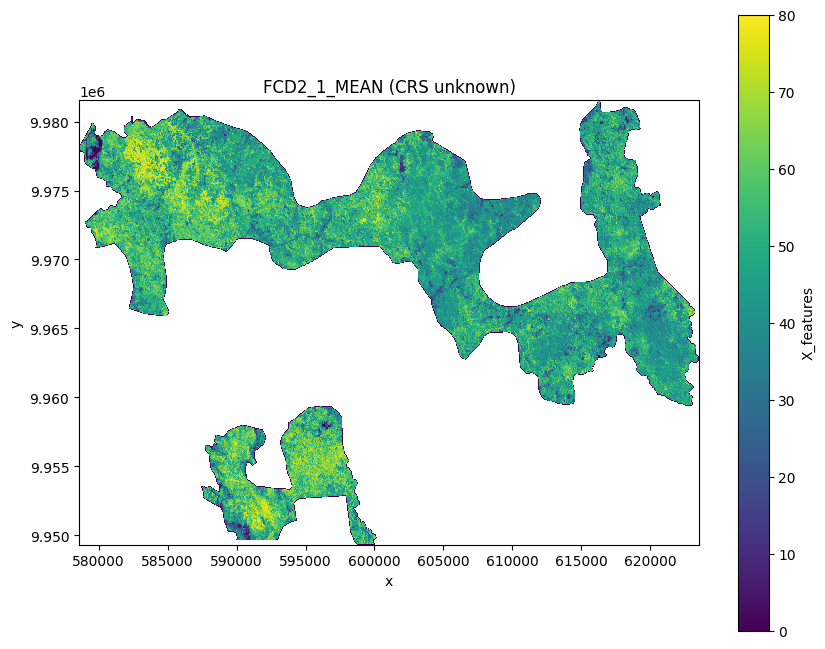

In [60]:
plot_unstack_ds(ds_stacked_formatted, band)

In [61]:
ds_stacked_formatted.sizes['sample']

4197230

In [62]:
### ONLY IN GT
import gc

# Check if it's a dask array - process in chunks to avoid memory issues
# CORRECT check: use hasattr(band_data.data, 'dask') NOT hasattr(.values, 'compute')
# because .values triggers computation for dask arrays!
is_dask = hasattr(ds_stacked_formatted.target.data, 'dask')
print(f"   Data is dask-backed (lazy): {is_dask}")

n_pixels_new = ds_stacked_formatted.sizes['sample']

if is_dask:
    # For dask arrays, check NaN per timestep and combine
    # A pixel is valid if it has at least one non-NaN value across time
    print(f"   Processing dask array in chunks to find valid pixels...")
    valid_mask = np.zeros(n_pixels_new, dtype=bool)
    chunk_size = 100000
    for i in range(0, n_pixels_new, chunk_size):
        end_idx = min(i + chunk_size, n_pixels_new)
        chunk_data = ds_stacked_formatted.target.isel(sample=slice(i, end_idx))
        chunk_values = chunk_data.compute().values  # Only compute this small chunk
        # Valid if has at least one non-NaN value across time
        chunk_valid = ~np.isnan(chunk_values)#.all(axis=0)
        valid_mask[i:end_idx] = chunk_valid
        del chunk_data, chunk_values
        gc.collect()
        if (i // chunk_size + 1) % 10 == 0:
            print(f"      Processed {i+chunk_size:,}/{n_pixels_new:,} pixels...")
    print(f"   ✅ Chunked processing complete")
else:
    print('   ⚠️  Data is regular numpy array (in memory)')
    print('   Consider running Cell 6 first to save to zarr and reload as dask!')
    # Regular numpy array - this will use memory
    band_values = ds_stacked_formatted.target.values
    # Valid if has at least one non-NaN value across time
    valid_mask = ~np.isnan(band_values)#.all(axis=0)
    del band_values
    gc.collect()

n_valid_pixels = valid_mask.sum()
print(f"   Valid pixels: {n_valid_pixels:,} ({n_valid_pixels/n_pixels_total*100:.1f}%)")
print(f"   NaN pixels (outside training area): {(~valid_mask).sum():,} ({(~valid_mask).sum()/n_pixels_total*100:.1f}%)")

# Get valid pixel indices
valid_pixel_indices = np.where(valid_mask)[0]
# valid_pixel_indices

ds_train_formatted = ds_stacked_formatted.isel(sample=valid_pixel_indices)

   Data is dask-backed (lazy): True
   Processing dask array in chunks to find valid pixels...
      Processed 1,000,000/4,197,230 pixels...
      Processed 2,000,000/4,197,230 pixels...
      Processed 3,000,000/4,197,230 pixels...
      Processed 4,000,000/4,197,230 pixels...
   ✅ Chunked processing complete
   Valid pixels: 60,774 (0.4%)
   NaN pixels (outside training area): 4,136,456 (28.5%)


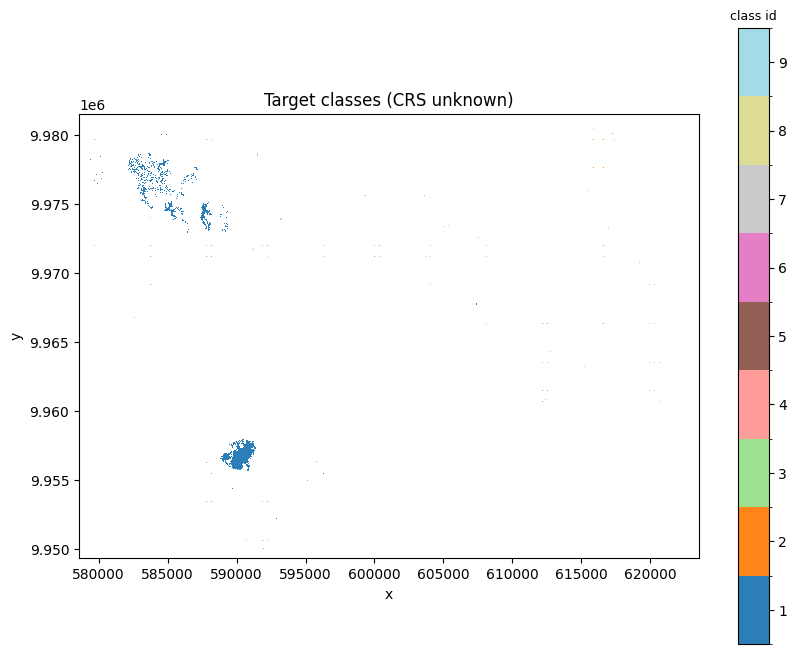

In [63]:
plot_unstack_ds(ds_stacked_formatted, band, y=True)

In [64]:
# ds_ml

In [65]:
# import pandas as pd
# import numpy as np

# ds = ds_ml_aoi

# # -------------------------------------------------
# # 1️⃣ Extract Dask-backed data ONCE
# # -------------------------------------------------
# # X_features: (sample, feature)
# X_da = ds.X_features

# # Convert to NumPy in one compute() call (fastest)
# X_np = X_da.data.compute() if hasattr(X_da.data, "compute") else X_da.data  
# # shape = (n_samples, n_features)

# feature_names = ds.feature.values.tolist()  # list of feature names

# # -------------------------------------------------
# # 2️⃣ Extract metadata columns (no loops)
# # -------------------------------------------------
# sample_np = ds.sample.values
# coord_x_np = ds.coord_x.values
# coord_y_np = ds.coord_y.values
# plot_id_np = ds.plot_id.values
# target_np = ds.target.values

# # -------------------------------------------------
# # 3️⃣ Efficient DataFrame assembly
# # -------------------------------------------------
# # Build the DataFrame WITHOUT Python loops
# df = pd.DataFrame(
#     data=X_np,
#     columns=feature_names,
# )

# # Add metadata (vectorized, no loops)
# df.insert(0, "sample", sample_np)
# df.insert(1, "coord_x", coord_x_np)
# df.insert(2, "coord_y", coord_y_np)
# df.insert(3, "plot_id", plot_id_np)
# df.insert(4, "target", target_np)

# print(f"✅ DataFrame created: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
# df.head()


In [66]:
# # ### Columns used to detect duplicates
# # feature_cols = df.columns.difference(
# #     ["sample", "coord_x", "coord_y", "plot_id", "target"]
# # )

# # duplicate_key_cols = ["plot_id", "target"] + feature_cols.tolist()

# # # Add a random number column
# # df["_rand"] = np.random.rand(len(df))

# # # Group by the duplicate key and keep 1 random row per group
# # df_unique = (
# #     df.loc[df.groupby(duplicate_key_cols)["_rand"].idxmax()]
# #     .drop(columns=["_rand"])
# #     .reset_index(drop=True)
# # )

# # print("Original rows:", len(df))
# # print("Unique rows:", len(df_unique))
# # df_unique.head()
# # try without removing duplicates
# df_unique=df


In [67]:
# # Define duplicate key columns
# duplicate_key_cols = ["plot_id", "target"] + feature_cols.tolist()

# # Flag duplicates (all rows in each duplicate group)
# df["is_duplicate"] = df.duplicated(duplicate_key_cols, keep=False)

# # Extract only duplicated rows
# df_dupes = df[df["is_duplicate"]].copy()

# print("Number of duplicate rows:", len(df_dupes))
# df_dupes.head()


In [78]:
# df.groupby(duplicate_key_cols)["_rand"].idxmax()

# ============================================================================
# STEP 5: CREATE XARRAY DATASET FOR TRAINING
# =========================================================================
# Goal: keep ds_train lazy + chunked, preserve feature order for later AOI alignment.
# Notes:
# - Avoid .values/.data to prevent accidental full compute; use .sizes for shapes.
# - Store feature order so we can reuse it when building the full-area stack.

import numpy as np
import xarray as xr

# X_features = df_unique

# # # Define column names for metadata (these will be excluded from features)
# # col_plot_id = 'plot_id'
# # col_index = 'sample'
# # col_y = 'target'
# # col_coord_x = 'coord_x'
# # col_coord_y = 'coord_y'

# # # Extract metadata columns
# # metadata_cols = [col_plot_id, col_index, col_y, col_coord_x, col_coord_y]
# # metadata_cols = [col for col in metadata_cols if col in X_features.columns]

# # # Extract feature columns (all columns except metadata)
# # feature_cols = [col for col in X_features.columns if col not in metadata_cols]

# # # Extract feature matrix and metadata
# # X_train = X_features[feature_cols].values
# # y_train = X_features[col_y].values
# # plot_train = X_features[col_plot_id].values
# # cords_x_train = X_features[col_coord_x].values
# # cords_y_train = X_features[col_coord_y].values

# # # Get dimensions
# # n_samples, n_features = X_train.shape

# # Create xarray Dataset for training
# ds_train = xr.Dataset(
#     {
#         "X_features": (("sample", "features"), X_train),  # Feature matrix
#         "y": (("sample",), y_train),  # Target labels (eligibility)
#         "plot_id": (("sample",), plot_train),  # Plot IDs
#         "coord_x": (("sample",), cords_x_train),  # X coordinates
#         "coord_y": (("sample",), cords_y_train)  # Y coordinates
#     },
#     coords={
#         "sample": np.arange(n_samples),
#         "features": feature_cols  # Feature column names as coordinates
#     }
# )

ds_train = ds_train_formatted

X_train = ds_train.X_features.data
y_train = ds_train.target.data
plot_train = ds_train.plot_id.data
cords_x_train = ds_train.coord_x.data
cords_y_train = ds_train.coord_y.data

n_samples = X_train.shape[0]
n_features = X_train.shape[1]

# ds_train = xr.Dataset(
#     {
#         "X_features": (("sample", "features"), X_train),  # Feature matrix
#         "y": (("sample",), y_train),  # Target labels (eligibility)
#         "plot_id": (("sample",), plot_train),  # Plot IDs
#         "coord_x": (("sample",), cords_x_train),  # X coordinates
#         "coord_y": (("sample",), cords_y_train)  # Y coordinates
#     },
#     coords={
#         "sample": np.arange(n_samples),
#         "features": feature_cols  # Feature column names as coordinates
#     }
# )

ds_train = ds_train.rename({'target':'y'})
ds_train = ds_train.assign(
    # ensure dim order and make feature a single chunk
    X_features=ds_train.X_features
        .transpose("sample", "feature"),
    # clean plot_id (fill NaNs and keep as string)
    plot_id=ds_train.plot_id.fillna("aoi_1").astype(str),
)

ds_train = ds_train.assign_attrs(crs=ds_aoi_unstack.rio.crs)

n_samples = int(ds_train.sizes.get("sample", 0))
n_features = int(ds_train.sizes.get("feature", 0))

# # Persist feature order for downstream AOI stacking
# if "feature" in ds_train.coords:
#     ds_train = ds_train.assign_attrs(feature_order=list(map(str, ds_train.coords["feature"].data)))

print(f"✅ Created ds_train with {n_samples:,} samples and {n_features} features")
print(f"   Variables: {list(ds_train.data_vars)}")
print(f"   Dimensions: {dict(ds_train.sizes)}")

✅ Created ds_train with 60,774 samples and 165 features
   Variables: ['coord_x', 'coord_y', 'plot_id', 'y', 'X_features']
   Dimensions: {'sample': 60774, 'feature': 165}


In [79]:
print(ds_train)

<xarray.Dataset> Size: 42MB
Dimensions:     (sample: 60774, feature: 165)
Coordinates:
  * feature     (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
  * sample      (sample) int64 486kB 122780 122796 122833 ... 14409734 14409771
Data variables:
    coord_x     (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    coord_y     (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    plot_id     (sample) <U1 243kB dask.array<chunksize=(60774,), meta=np.ndarray>
    y           (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    X_features  (sample, feature) float32 40MB dask.array<chunksize=(60774, 100), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749


In [80]:
# ds_train

In [81]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            31Gi        15Gi        14Gi        16Mi       1.9Gi        15Gi
Swap:             0B          0B          0B


In [82]:
ds_train

<xarray.Dataset> Size: 42MB
Dimensions:     (sample: 60774, feature: 165)
Coordinates:
  * feature     (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
  * sample      (sample) int64 486kB 122780 122796 122833 ... 14409734 14409771
Data variables:
    coord_x     (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    coord_y     (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    plot_id     (sample) <U1 243kB dask.array<chunksize=(60774,), meta=np.ndarray>
    y           (sample) float64 486kB dask.array<chunksize=(60774,), meta=np.ndarray>
    X_features  (sample, feature) float32 40MB dask.array<chunksize=(60774, 100), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [127]:
use_existing_ds_train = True
# zarr_path = './01_output/ds_train_planet_obia_arcgis_202409_202507_median.zarr'
zarr_path = 'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_train_planet_obia_arcgis_202409_202507_median.zarr'

# Align chunk sizes with current dask chunks to avoid zarr overlap errors
sample_chunk = ds_train.chunks.get("sample", (ds_train.sizes["sample"],))[0] if hasattr(ds_train, "chunks") else ds_train.sizes["sample"]
feature_chunk = ds_train.chunks.get("feature", (ds_train.sizes.get("feature", 1),))[0] if hasattr(ds_train, "chunks") and "feature" in ds_train.dims else ds_train.sizes.get("feature", 1)
chunk_sizes = {"sample": sample_chunk, "feature": feature_chunk}

if use_existing_ds_train:
    ds_train = load_dataset_zarr(zarr_path)
else:
    ds_to_save = ds_train.chunk(chunk_sizes)
    save_dataset_efficient_zarr(
        ds_to_save,
        zarr_path,
        chunk_sizes=chunk_sizes,
        overwrite=True,
        gee_compatible=False,
        align_chunks=True,
    )

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/ds_train_planet_obia_arcgis_202409_202507_median.zarr
✅ Dataset loaded: {'sample': 60774, 'feature': 165}


In [128]:
np.unique(ds_train['y'].values)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [129]:
# feature_cols
np.unique(y_train)
feature_cols = ds_train.coords['feature'].values.tolist()

In [130]:
# Quick check: Display feature column names
print(f"Total features: {len(feature_cols)}")
print(f"\nFirst 10 features: {feature_cols[:10]}")
print(f"\nLast 10 features: {feature_cols[-10:]}")

Total features: 165

First 10 features: ['ARVI_MAXIMUM', 'ARVI_MEAN', 'ARVI_MEDIAN', 'ARVI_MINIMUM', 'ARVI_STD', 'AVI_MAXIMUM', 'AVI_MEAN', 'AVI_MEDIAN', 'AVI_MINIMUM', 'AVI_STD']

Last 10 features: ['VIG_MAXIMUM', 'VIG_MEAN', 'VIG_MEDIAN', 'VIG_MINIMUM', 'VIG_STD', 'WDRVI_MAXIMUM', 'WDRVI_MEAN', 'WDRVI_MEDIAN', 'WDRVI_MINIMUM', 'WDRVI_STD']


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

def plot_class_distribution_by_plot(ds, target_col="y", plot_col="plot_id"):
    """Visualize class distribution across plots for any number of classes."""

    # Extract columns
    plot_ids = ds[plot_col]
    y = ds[target_col]

    # Convert to numpy and normalize plot IDs to strings to avoid mixed-type issues
    plot_ids = np.asarray(plot_ids)
    y = np.asarray(y)
    plot_ids = plot_ids.astype(str)

    # Detect unique classes dynamically
    classes = np.unique(y)
    n_classes = len(classes)

    # Generate consistent random colors for each class
    random.seed(42)
    all_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    random.shuffle(all_colors)
    class_colors = {cls: all_colors[i % len(all_colors)] for i, cls in enumerate(classes)}

    # Unique plots
    unique_plots = np.unique(plot_ids)

    # Count per plot
    plot_class_counts = {}
    for plot_id in unique_plots:
        mask = (plot_ids == plot_id)
        unique_vals, counts = np.unique(y[mask], return_counts=True)
        plot_class_counts[plot_id] = dict(zip(unique_vals, counts))

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -----------------------------
    # Plot 1 — Class distribution per plot
    # -----------------------------
    x = np.arange(len(unique_plots))
    width = 0.8 / n_classes  # width adjusts by number of classes

    for i, cls in enumerate(classes):
        counts = [plot_class_counts[p].get(cls, 0) for p in unique_plots]
        axes[0].bar(
            x + i * width - (width * n_classes / 2),
            counts,
            width,
            label=f'Class {cls}',
            color=class_colors[cls],
            alpha=0.8
        )

        # Add labels
        for j, c in enumerate(counts):
            if c > 0:
                axes[0].text(
                    j + i * width - (width * n_classes / 2),
                    c,
                    f"{c:,}",
                    ha="center",
                    va="bottom",
                    fontsize=8
                )

    axes[0].set_title("Class Distribution by Plot", fontsize=14)
    axes[0].set_xlabel("Plot ID")
    axes[0].set_ylabel("Sample Count")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(unique_plots, rotation=45, ha="right")
    axes[0].grid(axis="y", alpha=0.3)
    axes[0].legend()

    # -----------------------------
    # Plot 2 — Overall class distribution
    # -----------------------------
    cls_unique, cls_counts = np.unique(y, return_counts=True)
    bars = axes[1].bar(
        cls_unique,
        cls_counts,
        color=[class_colors[c] for c in cls_unique],
        edgecolor="black",
        linewidth=1.5
    )

    axes[1].set_title("Overall Class Distribution", fontsize=14)
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Sample Count")
    axes[1].set_xticks(cls_unique)
    axes[1].set_xticklabels([f"{c}" for c in cls_unique])
    axes[1].grid(axis="y", alpha=0.3)

    total = len(y)
    for bar, count in zip(bars, cls_counts):
        pct = (count / total) * 100
        axes[1].text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{count:,}\n({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Print statistics
    # -----------------------------
    print("\n" + "=" * 60)
    print("CLASS DISTRIBUTION STATISTICS")
    print("=" * 60)
    print(f"Total samples: {total:,}\n")
    for cls, count in zip(cls_unique, cls_counts):
        pct = count / total * 100
        print(f"Class {cls}: {count:,} samples ({pct:.2f}%)")
    print(f"\nImbalance ratio: {max(cls_counts) / min(cls_counts):.2f}:1\n")

    print("Per-plot breakdown:")
    for plot_id in unique_plots:
        stats = plot_class_counts[plot_id]
        total_plot = sum(stats.values())
        print(f"  {plot_id}: ", end="")
        for cls in classes:
            c = stats.get(cls, 0)
            pct = c / total_plot * 100 if total_plot > 0 else 0
            print(f"Class {cls}={c:,} ({pct:.1f}%)  ", end="")
        print("")
    print("=" * 60)


In [132]:
import numpy as np

class_id = 1
n_drop = 52000  # number to remove
rng = np.random.default_rng(42)

# Find class-1 indices
mask = (ds_train.y == class_id).values
idx = np.where(mask)[0]

print(f"Class {class_id} count before: {idx.size:,}")

if idx.size <= n_drop:
    print(f"⚠️ Only {idx.size:,} class-{class_id} samples; cannot drop {n_drop:,}.")
    n_drop = idx.size - 1  # keep at least one
    print(f"   Dropping {n_drop:,} instead.")

if n_drop > 0:
    drop_idx = rng.choice(idx, size=n_drop, replace=False)
    keep_idx = np.setdiff1d(np.arange(ds_train.sizes["sample"]), drop_idx)
    ds_train = ds_train.isel(sample=keep_idx)

print(f"Class {class_id} count after: {int((ds_train.y == class_id).sum().compute().item()):,}")
print("NaNs in y:", int(np.isnan(ds_train.y.values).sum()))
print(f"New dataset dimensions: {ds_train.sizes}")

Class 1 count before: 57,004
Class 1 count after: 5,004
NaNs in y: 0
New dataset dimensions: Frozen({'sample': 8774, 'feature': 165})


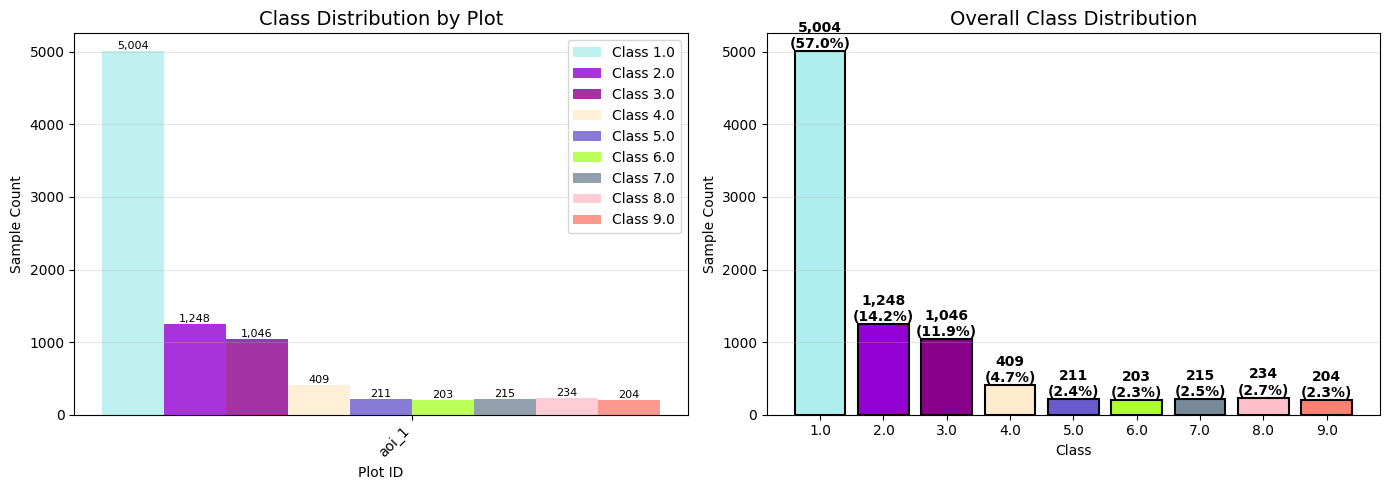


CLASS DISTRIBUTION STATISTICS
Total samples: 8,774

Class 1.0: 5,004 samples (57.03%)
Class 2.0: 1,248 samples (14.22%)
Class 3.0: 1,046 samples (11.92%)
Class 4.0: 409 samples (4.66%)
Class 5.0: 211 samples (2.40%)
Class 6.0: 203 samples (2.31%)
Class 7.0: 215 samples (2.45%)
Class 8.0: 234 samples (2.67%)
Class 9.0: 204 samples (2.33%)

Imbalance ratio: 24.65:1

Per-plot breakdown:
  aoi_1: Class 1.0=5,004 (57.0%)  Class 2.0=1,248 (14.2%)  Class 3.0=1,046 (11.9%)  Class 4.0=409 (4.7%)  Class 5.0=211 (2.4%)  Class 6.0=203 (2.3%)  Class 7.0=215 (2.5%)  Class 8.0=234 (2.7%)  Class 9.0=204 (2.3%)  


In [133]:
# overwrite plot_id safely as a data variable
plot_values = np.full(ds_train.dims["sample"], "aoi_1", dtype=object)
ds_train = ds_train.drop_vars("plot_id", errors="ignore").assign(plot_id=("sample", plot_values))
plot_class_distribution_by_plot(ds_train)

In [134]:
point_training_non_forest.groupby('type').size()

type
2    1248
3    1046
4     409
5     213
6     203
7     215
8     235
9     205
dtype: int64

In [135]:
# !pip install scikit-learn

In [136]:
# ============================================================================
# STEP 5.6: CALCULATE OPTIMAL CLASS WEIGHTS
# ============================================================================
# Calculate balanced class weights to handle imbalance without losing data

from sklearn.utils.class_weight import compute_class_weight

import numpy as np

def calculate_optimal_class_weights(y):
    """
    Calculate balanced class weights automatically for ANY number of classes.

    Parameters
    ----------
    y : array-like
        Target labels.

    Returns
    -------
    list
        Class weights in the order of sorted unique classes.
    """

    # Extract unique classes
    classes = np.unique(y)

    # Compute balanced class weights
    weights = compute_class_weight(
        class_weight='balanced', 
        classes=classes, 
        y=y
    )

    # Pair class_id → weight
    weight_dict = dict(zip(classes, weights))

    # ------------------------
    # Pretty console output
    # ------------------------
    print("=" * 60)
    print("OPTIMAL CLASS WEIGHTS (AUTO-DETECTED CLASSES)")
    print("=" * 60)
    total_samples = len(y)
    print(f"Detected classes: {classes.tolist()}")
    print(f"Total samples: {total_samples:,}\n")

    for cls in classes:
        count = np.sum(y == cls)
        pct = (count / total_samples) * 100
        w = weight_dict[cls]
        print(f"Class {cls:>3}:  count={count:>8,} ({pct:5.2f}%)   weight={w:.4f}")

    print("=" * 60)
    print(f"Class weights vector for model:")
    print(f"{list(weights)}")
    print("=" * 60)

    # For CatBoost, return as list
    return list(weights)


# Calculate optimal weights from your data
y_all = ds_train.y.values
optimal_weights = calculate_optimal_class_weights(y_all)

print(f"\n💡 To use these weights, update your model_config:")
print(f"   class_weights={optimal_weights}")
print(f"\n   Example:")
print(f"   model_config = dict(")
print(f"       ...")
print(f"       class_weights={optimal_weights},  # Balanced weights")
print(f"       ...")
print(f"   )")


OPTIMAL CLASS WEIGHTS (AUTO-DETECTED CLASSES)
Detected classes: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
Total samples: 8,774

Class 1.0:  count=   5,004 (57.03%)   weight=0.1948
Class 2.0:  count=   1,248 (14.22%)   weight=0.7812
Class 3.0:  count=   1,046 (11.92%)   weight=0.9320
Class 4.0:  count=     409 ( 4.66%)   weight=2.3836
Class 5.0:  count=     211 ( 2.40%)   weight=4.6203
Class 6.0:  count=     203 ( 2.31%)   weight=4.8024
Class 7.0:  count=     215 ( 2.45%)   weight=4.5344
Class 8.0:  count=     234 ( 2.67%)   weight=4.1662
Class 9.0:  count=     204 ( 2.33%)   weight=4.7789
Class weights vector for model:
[np.float64(0.1948219202415845), np.float64(0.7811609686609686), np.float64(0.9320161461652857), np.float64(2.3835914153762565), np.float64(4.620326487625066), np.float64(4.802408319649699), np.float64(4.5343669250645995), np.float64(4.1661918328585), np.float64(4.778867102396514)]

💡 To use these weights, update your model_config:
   class_weights=[np.float64(0.194

In [137]:
# !pip install statsmodels

In [138]:
# # # Convert X_features (samples x features) to DataFrame
# import pandas as pd
# import numpy as np


# X_da = ds_train.X_features

# # # Convert to NumPy in one compute() call (fastest)
# X_np = X_da.data.compute() if hasattr(X_da.data, "compute") else X_da.data  
# # shape = (n_samples, n_features)

# feature_names = ds_train.coords['features'].values.tolist()  # list of feature names

# # -------------------------------------------------
# # 2️⃣ Extract metadata columns (no loops)
# # -------------------------------------------------
# sample_np = ds_train.sample.values
# coord_x_np = ds_train.coord_x.values
# coord_y_np = ds_train.coord_y.values
# plot_id_np = ds_train.plot_id.values
# target_np = ds_train.y.values

# # -------------------------------------------------
# # 3️⃣ Efficient DataFrame assembly
# # -------------------------------------------------
# # Build the DataFrame WITHOUT Python loops
# df = pd.DataFrame(
#     data=X_np,
#     columns=feature_names,
# )

# # Add metadata (vectorized, no loops)
# df.insert(0, "sample", sample_np)
# df.insert(1, "coord_x", coord_x_np)
# df.insert(2, "coord_y", coord_y_np)
# df.insert(3, "plot_id", plot_id_np)
# df.insert(4, "target", target_np)

# print(f"✅ DataFrame created: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
# df.head()

In [139]:
# # ============================================================================
# # STEP 5.7: MULTICOLLINEARITY CHECK
# # ============================================================================
# # Check for highly correlated features and remove redundant ones
# # This should be done BEFORE model training to improve model stability and performance

# # PROBABLY THIS ONE FOR LINEAR ONLY, but without this one, accuracy is low, lets see

# import pandas as pd
# import numpy as np
# import xarray as xr
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import warnings
# warnings.filterwarnings('ignore')

# def check_multicollinearity(X_features_df, correlation_threshold=0.95, vif_threshold=10.0):
#     """
#     Check for multicollinearity using correlation matrix and VIF
    
#     Parameters:
#     -----------
#     X_features_df : pd.DataFrame
#         DataFrame with features (columns) and samples (rows)
#     correlation_threshold : float
#         Threshold for correlation (default: 0.95)
#     vif_threshold : float
#         Threshold for VIF (default: 10.0)
        
#     Returns:
#     --------
#     results : dict
#         Dictionary with correlation pairs, VIF scores, and recommendations
#     """
#     print("=" * 60)
#     print("MULTICOLLINEARITY CHECK")
#     print("=" * 60)
#     print(f"Total features: {X_features_df.shape[1]}")
#     print(f"Total samples: {X_features_df.shape[0]}\n")
    
#     # 1. Correlation Matrix Analysis
#     print("📊 Step 1: Correlation Matrix Analysis")
#     print("-" * 60)
#     corr_matrix = X_features_df.corr().abs()
    
#     # Find highly correlated pairs (excluding diagonal)
#     high_corr_pairs = []
#     upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i+1, len(corr_matrix.columns)):
#             corr_value = corr_matrix.iloc[i, j]
#             if corr_value >= correlation_threshold:
#                 high_corr_pairs.append({
#                     'feature1': corr_matrix.columns[i],
#                     'feature2': corr_matrix.columns[j],
#                     'correlation': corr_value
#                 })
    
#     if high_corr_pairs:
#         print(f"⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs (|r| >= {correlation_threshold}):")
#         # Sort by correlation value
#         high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True)
#         for idx, pair in enumerate(high_corr_pairs_sorted[:20]):  # Show top 20
#             print(f"   {idx+1}. {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.4f}")
#         if len(high_corr_pairs) > 20:
#             print(f"   ... and {len(high_corr_pairs) - 20} more pairs")
#     else:
#         print(f"✅ No highly correlated pairs found (threshold: {correlation_threshold})")
    
#     # 2. VIF Analysis (Variance Inflation Factor)
#     print(f"\n📊 Step 2: VIF Analysis (Variance Inflation Factor)")
#     print("-" * 60)
    
#     # Select numeric columns only and handle any remaining NaN values
#     X_numeric = X_features_df.select_dtypes(include=[np.number])
#     X_numeric = X_numeric.fillna(X_numeric.mean())  # Fill NaN with mean
    
#     # Limit to first 100 features for VIF calculation (VIF is computationally expensive)
#     # If you have many features, calculate VIF on a sample
#     if X_numeric.shape[1] > 400:
#         print(f"⚠️ Too many features ({X_numeric.shape[1]}) for full VIF calculation.")
#         print(f"   Calculating VIF on first 100 features as sample...")
#         X_vif = X_numeric.iloc[:, :400]
#         feature_names_vif = X_vif.columns.tolist()
#     else:
#         X_vif = X_numeric
#         feature_names_vif = X_vif.columns.tolist()
    
#     try:
#         vif_data = pd.DataFrame()
#         vif_data["Feature"] = feature_names_vif
#         vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
#                           for i in range(X_vif.shape[1])]
        
#         high_vif_features = vif_data[vif_data["VIF"] > vif_threshold].sort_values("VIF", ascending=False)
        
#         if len(high_vif_features) > 0:
#             print(f"⚠️ Found {len(high_vif_features)} features with high VIF (VIF > {vif_threshold}):")
#             for idx, row in high_vif_features.head(20).iterrows():
#                 print(f"   {row['Feature']}: VIF = {row['VIF']:.2f}")
#             if len(high_vif_features) > 20:
#                 print(f"   ... and {len(high_vif_features) - 20} more features")
#         else:
#             print(f"✅ No features with high VIF found (threshold: {vif_threshold})")
            
#     except Exception as e:
#         print(f"⚠️ Could not calculate VIF: {str(e)}")
#         print("   (This is normal for very large datasets)")
#         high_vif_features = pd.DataFrame()
#         vif_data = pd.DataFrame()
    
#     # 3. Recommendations
#     print(f"\n💡 Recommendations:")
#     print("-" * 60)
    
#     features_to_remove = set()
    
#     # From correlation analysis
#     if high_corr_pairs:
#         # For each pair, remove one feature (prefer shorter name or first one)
#         for pair in high_corr_pairs_sorted:
#             feat1, feat2 = pair['feature1'], pair['feature2']
#             if feat1 not in features_to_remove and feat2 not in features_to_remove:
#                 # Remove the second feature (arbitrary choice - could be improved)
#                 features_to_remove.add(feat2)
        
#         print(f"   From correlation: Remove {len(features_to_remove)} features")
    
#     # From VIF analysis
#     if len(high_vif_features) > 0:
#         vif_features_to_remove = set(high_vif_features['Feature'].tolist())
#         features_to_remove.update(vif_features_to_remove)
#         print(f"   From VIF: {len(vif_features_to_remove)} features flagged")
    
#     total_to_remove = len(features_to_remove)
#     remaining_features = X_features_df.shape[1] - total_to_remove
    
#     print(f"\n   Total features to consider removing: {total_to_remove}")
#     print(f"   Remaining features after removal: {remaining_features}")
#     print(f"   Reduction: {(total_to_remove/X_features_df.shape[1]*100):.1f}%")
    
#     return {
#         'correlation_pairs': high_corr_pairs,
#         'vif_scores': vif_data if 'vif_data' in locals() else pd.DataFrame(),
#         'high_vif_features': high_vif_features if 'high_vif_features' in locals() else pd.DataFrame(),
#         'features_to_remove': list(features_to_remove),
#         'correlation_matrix': corr_matrix
#     }

# def remove_multicollinear_features_from_dataset(ds, feature_names, features_to_remove):
#     """
#     Remove multicollinear features from dataset
    
#     Parameters:
#     -----------
#     ds : xarray.Dataset
#         Original dataset with X_features as (sample, features) array
#     feature_names : list
#         List of all feature names in order (e.g., ['EVI__minimum', 'EVI__mean', ...])
#     features_to_remove : list
#         List of feature names to remove
        
#     Returns:
#     --------
#     ds_filtered : xarray.Dataset
#         Dataset with multicollinear features removed
#     feature_names_filtered : list
#         List of remaining feature names
#     """
#     if not features_to_remove:
#         print("✅ No features to remove")
#         return ds, feature_names
    
#     # Find indices of features to keep
#     keep_indices = [i for i, name in enumerate(feature_names) if name not in features_to_remove]
#     feature_names_filtered = [name for name in feature_names if name not in features_to_remove]
    
#     # X_features is stored as (sample, features) - remove columns
#     X_filtered = ds.X_features.values[:, keep_indices]
    
#     # Create new dataset with filtered features
#     # Need to recreate the dataset to avoid coordinate dimension conflicts
#     ds_filtered = xr.Dataset(
#         {
#             "X_features": (("sample", "features"), X_filtered),
#             "y": (("sample",), ds.y.values),
#             "plot_id": (("sample",), ds.plot_id.values),
#             "coord_x": (("sample",), ds.coord_x.values),
#             "coord_y": (("sample",), ds.coord_y.values)
#         },
#         coords={
#             "sample": ds.sample.values,
#             "features": feature_names_filtered  # Use filtered feature names as coordinates
#         }
#     )
    
#     print(f"✅ Removed {len(features_to_remove)} multicollinear features")
#     print(f"   Remaining features: {len(feature_names_filtered)}")
    
#     return ds_filtered, feature_names_filtered

# # Perform multicollinearity check
# print("🔍 Performing multicollinearity check on features...\n")

# feature_names = feature_cols
# # Build a flat DataFrame of the stacked samples
# # feature_names = ds_train.feature.values
# X_df = pd.DataFrame(ds_train.X_features.values, columns=feature_names)

# # Convert X_features to DataFrame for analysis
# X_features_df = X_df

# # Run multicollinearity check
# multicollinearity_results = check_multicollinearity(
#     X_features_df, 
#     correlation_threshold=0.95,  # Adjust threshold as needed (0.95 = very high correlation)
#     vif_threshold=10.0  # VIF > 10 indicates multicollinearity
# )

# print("\n" + "=" * 60)
# print("✅ Multicollinearity check completed!")
# print("=" * 60)

# ###Optional: Remove highly correlated features
# ####Uncomment the following lines to automatically remove multicollinear features
# if multicollinearity_results['features_to_remove']:
#     print("\n🗑️ Removing multicollinear features...")
#     ds_train_filtered, feature_names_filtered = remove_multicollinear_features_from_dataset(
#         ds_train, 
#         feature_names,
#         multicollinearity_results['features_to_remove']
#     )
#     print("✅ Dataset filtered. Use 'ds_train_filtered' for training instead of 'ds_train'")
#     print("   Note: Update feature_names to 'feature_names_filtered' if you use filtered dataset")
# else:
#     print("\n✅ No features removed. Dataset is ready for training.")

In [140]:
# !pip install catboost

In [141]:
# !pip install scikit-image

In [142]:
# ============================================================================
# STEP 6: IMPORT ALL REQUIRED LIBRARIES
# ============================================================================
# Import all necessary libraries for model training and evaluation

import pandas as pd
import numpy as np
import xarray as xr
import os
import json
import hashlib
from datetime import datetime
import glob

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing (for post-processing predictions)
from skimage.morphology import remove_small_objects
from scipy.ndimage import generic_filter
from skimage.segmentation import clear_border

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [143]:
# ============================================================================
# STEP 7: DEFINE UTILITY FUNCTIONS
# ============================================================================
# Define helper functions for model training and evaluation
def get_class_names(y, class_label_map=None):
    """
    Returns ordered class names dynamically.
    y: numpy array of integer class labels
    class_label_map: optional dict (e.g., {1: "Eligible", 2: "Not Eligible"})
    """
    classes = np.unique(y)

    if class_label_map is not None:
        # map provided names
        return [class_label_map[int(c)] for c in classes]

    # fallback generic names
    return [f"Class {int(c)}" for c in classes]


def prepare_config(model_config, plot_ids, input_config=dict(), use_proba=False, optimal_threshold=0.5):
    """
    Prepare configuration with unique hash based on model settings and threshold
    
    Parameters:
    -----------
    use_proba : bool
        Whether using probability-based predictions (affects hash)
    optimal_threshold : float
        Threshold value (affects hash to ensure different configs get different cache)
    """
    # Convert numpy array to list for JSON serialization
    if isinstance(plot_ids, np.ndarray):
        plot_ids_list = plot_ids.tolist()
    else:
        plot_ids_list = list(plot_ids)
    
    config = {'model': model_config, 'plots': plot_ids_list, 'sample_weight': True}
    # merge config with input_config
    config.update(input_config)
    
    # Add threshold info to config for tracking
    config['use_proba'] = use_proba
    config['optimal_threshold'] = optimal_threshold
    
    # Create a copy of config for hashing (without verbose for consistency)
    config_for_hash = config.copy()
    if 'verbose' in config_for_hash['model']:
        config_for_hash['model'] = config_for_hash['model'].copy()
        del config_for_hash['model']['verbose']
    
    # Include threshold and use_proba in hash to ensure different configs get different cache
    config_for_hash['hash_meta'] = {
        'use_proba': use_proba,
        'optimal_threshold': optimal_threshold
    }
    
    config['hash'] = hashlib.md5(json.dumps(config_for_hash, sort_keys=True).encode('utf-8')).hexdigest()
    
    if 'verbose' in config['model']:
        del config['model']['verbose']
    
    # create cache directory if it does not exist
    if not os.path.exists(f"/mnt/data/cache/{config['hash']}"):
        os.makedirs(f"/mnt/data/cache/{config['hash']}", exist_ok=True)
        json.dump(config, open(f"/mnt/data/cache/{config['hash']}/config.json", 'w'))

    return config
    
def plot_confusion_matrix(
    y_true,
    y_pred,
    class_label_map=None,
    sample_weight=None,
    dataset="training"
):
    # dynamic class names
    class_names = get_class_names(y_true, class_label_map)

    # Short labels for axes
    class_ids = [f"Class {i}" for i in range(len(class_names))]

    cm = confusion_matrix(
        y_true, y_pred, normalize='true', sample_weight=sample_weight
    )

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Annotate cell values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, f"{cm[i, j]:.2f}",
                ha='center', va='center',
                color='white' if cm[i, j] > 0.5 else 'black'
            )

    # Axis ticks using short class labels
    ax.set_xticks(range(len(class_ids)))
    ax.set_xticklabels(class_ids, rotation=45, ha='right')

    ax.set_yticks(range(len(class_ids)))
    ax.set_yticklabels(class_ids)

    # Labels and title
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix ({dataset})")

    # Color bar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # -------------------------------------------------
    # 🔥 LEGEND WITH FULL CLASS NAMES ON THE RIGHT
    # -------------------------------------------------
    handles = [
        plt.Line2D([0], [0], color='white', marker='s', markersize=10, label=f"{cid} → {name}")
        for cid, name in zip(class_ids, class_names)
    ]
    ax.legend(
        handles=handles,
        title="Class Mapping",
        loc='center left',
        bbox_to_anchor=(1.25, 0.5),
        frameon=True
    )

    plt.tight_layout()
    plt.show()


def plot_roc_curve(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]
    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    # Compute area under the ROC curve
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_classification_report(y_true, y_pred, class_label_map=None, figsize=(8,6), cmap='Blues', sample_weight=None):
    class_names = get_class_names(y_true, class_label_map)

    report_dict = classification_report(y_true, y_pred,
                                        target_names=class_names,
                                        output_dict=True,
                                        sample_weight=sample_weight)

    report_df = pd.DataFrame(report_dict).T
    report_df = report_df.iloc[:-3, :-1]  # remove accuracy/support

    plt.figure(figsize=figsize)
    sns.heatmap(report_df.astype(float), annot=True, cmap=cmap, cbar=False, fmt=".2f")
    plt.title("Classification Report")
    plt.ylabel("Classes")
    plt.xlabel("Metrics")
    plt.yticks(rotation=0)
    plt.show()


def plot_roc_curve2(X_features, y, model):
    # Compute predicted probabilities for the positive class
    y_scores = model.predict_proba(X_features)[:, 1]

    # Calculate false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve')
    # fill area under the ROC curve
    plt.fill_between(fpr, tpr, color='blue', alpha=0.2, 
                     label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

    # Annotate thresholds every Nth point
    step = max(1, len(thresholds) // 20)
    for idx in range(0, len(thresholds), step):
        plt.text(fpr[idx], tpr[idx], f"{thresholds[idx]:.2f}",
                 fontsize=8, ha='center', va='bottom', color='red')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(model, X, y, class_label_map=None):
    # Map numeric → text labels if needed
    if class_label_map:
        classes = list(class_label_map.keys())
    else:
        classes = np.unique(y)

    n_classes = len(classes)

    # Binarize labels: shape (n_samples, n_classes)
    y_bin = label_binarize(y, classes=classes)

    # Predict class probabilities
    y_score = model.predict_proba(X)

    plt.figure(figsize=(10, 8))

    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        label = f"Class {cls}"
        if class_label_map:
            label += f" → {class_label_map[cls]} (AUC={roc_auc:.2f})"
        else:
            label += f" (AUC={roc_auc:.2f})"

        plt.plot(fpr, tpr, lw=2, label=label)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve (One-vs-Rest)")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()

In [144]:
# ============================================================================
# STEP 8: DEFINE TRAINING FUNCTION
# ============================================================================
# Function to train a single model on the entire dataset

def train_full_area_model(ds_full, config, validation_split=0.2, random_seed=42):
    """
    Train a single model on the entire dataset (all plots combined)
    
    Parameters:
    -----------
    ds_full : xarray.Dataset
        Full dataset with all plots
    config : dict
        Model config (must include config['label_map'] = {class_id: label_string})
    validation_split : float
        Fraction of data to use for validation
    random_seed : int
        Seed for reproducible split
    """

    # -------------------------------
    # Extract dynamic label mapping
    # -------------------------------
    label_map = config.get("label_map", None)

    # If no label_map provided, construct fallback
    if label_map is None:
        classes = np.unique(ds_full.y.values)
        label_map = {cls: f"Class {cls}" for cls in classes}

    # Sort labels by class id (required by sklearn)
    sorted_classes = sorted(label_map.keys())
    target_names = [label_map[c] for c in sorted_classes]

    # -------------------------------
    # Extract X and y
    # -------------------------------
    X_all = ds_full.X_features.values
    y_all = ds_full.y.values

    from sklearn.model_selection import train_test_split

    train_indices, val_indices = train_test_split(
        np.arange(len(X_all)),
        test_size=validation_split,
        random_state=random_seed,
        stratify=y_all
    )

    X_train = X_all[train_indices]
    X_val = X_all[val_indices]
    y_train = y_all[train_indices]
    y_val = y_all[val_indices]

    config['train_indices'] = train_indices.tolist()
    config['val_indices'] = val_indices.tolist()

    print(f"📊 Training on full area:")
    print(f"   Train samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}")
    print(f"   Total features: {X_train.shape[1]}")
    if 'class_weights' in config['model']:
        print(f"   Class weights: {config['model']['class_weights']}")

    # Train model
    catboost_model = CatBoostClassifier(**config['model'])

    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=config['model'].get('verbose', 100)
    )

    # Save model
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"/mnt/data/cache/{config['hash']}/catboost_{timestamp}.cbm"
    catboost_model.save_model(model_path)
    print(f"✅ Model saved to: {model_path}")

    config['model_path'] = model_path
    config['timestamp'] = timestamp

    # -------------------------------
    # Evaluation with dynamic labels
    # -------------------------------
    from sklearn.metrics import accuracy_score, classification_report

    y_val_pred = catboost_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    print(f"\n📈 Validation Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:")
    print(classification_report(
        y_val,
        y_val_pred,
        labels=sorted_classes,
        target_names=target_names
    ))

    return catboost_model, model_path



def load_full_area_model(config, timestamp=None):
    """
    Load the saved full-area model for inference
    
    Parameters:
    -----------
    config : dict
        Configuration dictionary (must have 'hash' key)
    timestamp : str, optional
        Specific timestamp to load (format: YYYYMMDD_HHMMSS)
        If None, loads the latest model or uses config['model_path']
        
    Returns:
    --------
    model : CatBoostClassifier
        Loaded model ready for prediction
    model_path : str
        Path to the loaded model
    """
    # If timestamp is provided, use it
    if timestamp:
        model_path = f"/mnt/data/cache/{config['hash']}/catboost_{timestamp}.cbm"
    # If config has model_path stored, use it
    elif 'model_path' in config:
        model_path = config['model_path']
    # Otherwise, find the latest model
    else:
        cache_dir = f"/mnt/data/cache/{config['hash']}"
        model_files = glob.glob(f"{cache_dir}/catboost_*.cbm")
        
        if not model_files:
            raise FileNotFoundError(f"No models found in {cache_dir}")
        
        # Sort by modification time and get the latest
        model_path = max(model_files, key=os.path.getmtime)
        print(f"📂 Found latest model: {os.path.basename(model_path)}")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at: {model_path}")
    
    model = CatBoostClassifier()
    model.load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")
    
    return model, model_path

print("✅ Training functions defined")


✅ Training functions defined


In [145]:
np.unique(ds_train.y.values)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [146]:
print(ds_train)

<xarray.Dataset> Size: 6MB
Dimensions:     (sample: 8774, feature: 165)
Coordinates:
  * feature     (feature) object 1kB 'ARVI_MAXIMUM' 'ARVI_MEAN' ... 'WDRVI_STD'
  * sample      (sample) int64 70kB 122780 122796 122833 ... 14409734 14409771
Data variables:
    coord_x     (sample) float64 70kB dask.array<chunksize=(8774,), meta=np.ndarray>
    coord_y     (sample) float64 70kB dask.array<chunksize=(8774,), meta=np.ndarray>
    X_features  (sample, feature) float32 6MB dask.array<chunksize=(8774, 100), meta=np.ndarray>
    y           (sample) float64 70kB dask.array<chunksize=(8774,), meta=np.ndarray>
    plot_id     (sample) object 70kB 'aoi_1' 'aoi_1' 'aoi_1' ... 'aoi_1' 'aoi_1'


In [147]:
# ============================================================================
# STEP 9: CONFIGURE AND TRAIN MODEL (memory-safe subset)
# ============================================================================
# Now compute small object
ds_train = ds_train.compute()

### Get plot IDs for config (needed for hash generation)
plot_ids = np.unique(ds_train.plot_id.values)
print(f"📊 Found {len(plot_ids)} unique plots: {plot_ids}")

class_weights_to_use = [float(w) for w in optimal_weights]
print(f"✅ Using calculated optimal class weights: {class_weights_to_use}")

# Define CatBoost model configuration (lighter to reduce OOM risk)
model_config = dict(
    iterations=30000,
    learning_rate=0.01,
    eval_metric='MultiClass',        # Evaluation metric
    l2_leaf_reg=6,                # L2 regularization
    random_seed=42,                # Random seed for reproducibility
    early_stopping_rounds=300,    # Stop if no improvement for a while
    verbose=100,                  # Print progress every 100 iterations
    use_best_model=True,          # Use best model from validation
    depth=4,                      # Tree depth
    class_weights=class_weights_to_use,  # Optimal balanced weights (or default)
)

class_label_map = {
                1: 'forest_trees',
                2: 'shrubland',
                3: 'grassland',
                4: 'openland',
                5: 'waterbody_waterlogged',
                6: 'plantation',
                7: 'gray_infrastructure',
                8: 'oil_palm',
                9: 'cropland',
                # 10:'waterbody',
                # 14: 'paddy_irrigated',
            }

# Prepare configuration with unique hash
# Note: We're using class_weights (set above using optimal_weights) to handle class imbalance
#       This is more effective than sample weights for this use case
config_full = prepare_config(
    model_config, 
    plot_ids, 
    {'force_retrain': True,
    "label_map": class_label_map},  # Not using sample weights - class_weights handle imbalance
)

# config_full['label_map'] = class_label_map


print(f"📝 Config hash: {config_full['hash']}")

# Train single model on subsetted, dense data
print("\n🚀 Training single model on entire area (subsetted/dense)...")
print("=" * 60)
model_full, model_path = train_full_area_model(
    ds_train, 
    config_full, 
    validation_split=0.2,  # 20% for validation, 80% for training
    random_seed=42
)

print("\n" + "=" * 60)
print("✅ Single model trained and saved!")
print(f"   Model path: {model_path}")
print(f"   Timestamp: {config_full.get('timestamp', 'N/A')}")
print(f"   Config hash: {config_full['hash']}")

📊 Found 1 unique plots: ['aoi_1']
✅ Using calculated optimal class weights: [0.1948219202415845, 0.7811609686609686, 0.9320161461652857, 2.3835914153762565, 4.620326487625066, 4.802408319649699, 4.5343669250645995, 4.1661918328585, 4.778867102396514]
📝 Config hash: 76e5816d18ad0513c236ca3554a07ba8

🚀 Training single model on entire area (subsetted/dense)...
📊 Training on full area:
   Train samples: 7,019
   Validation samples: 1,755
   Total features: 165
   Class weights: [0.1948219202415845, 0.7811609686609686, 0.9320161461652857, 2.3835914153762565, 4.620326487625066, 4.802408319649699, 4.5343669250645995, 4.1661918328585, 4.778867102396514]
0:	learn: 2.1825746	test: 2.1812236	best: 2.1812236 (0)	total: 44.2ms	remaining: 22m 5s
100:	learn: 1.5171693	test: 1.5123690	best: 1.5123690 (100)	total: 3.23s	remaining: 15m 57s
200:	learn: 1.2965749	test: 1.2968429	best: 1.2968429 (200)	total: 6.46s	remaining: 15m 57s
300:	learn: 1.1819156	test: 1.1904933	best: 1.1904933 (300)	total: 9.75s	r

✅ Using model from training
✅ Using stored train/val split indices from training

📊 Model Performance Summary:
   Training Accuracy: 0.8873
   Validation Accuracy: 0.8057

📈 Confusion Matrix (Validation Set):


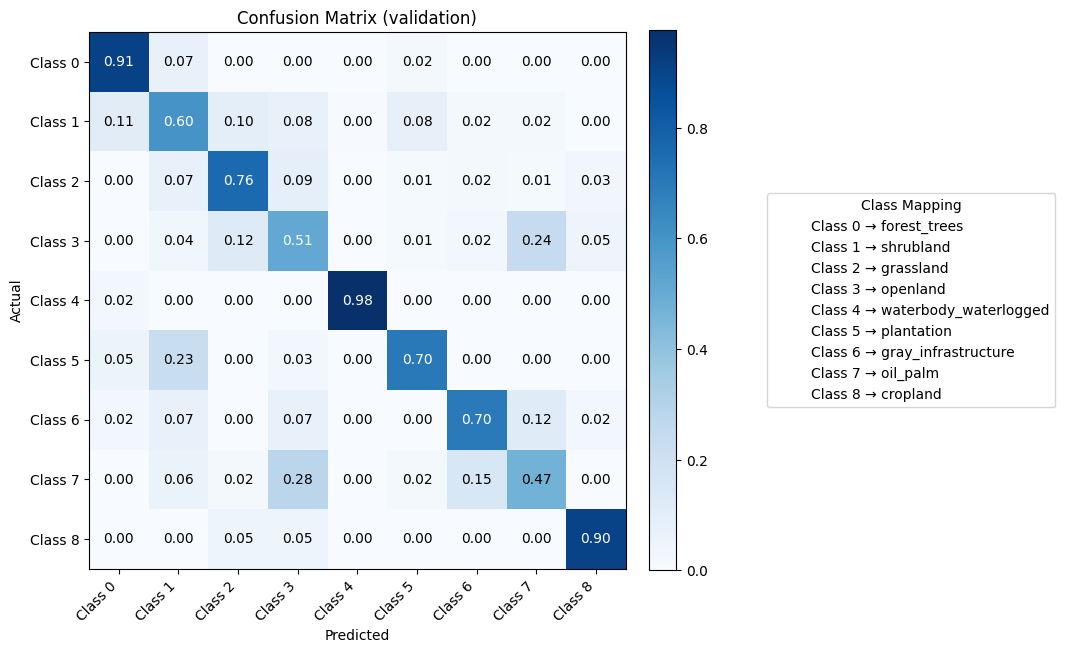

In [148]:
# ============================================================================
# STEP 10: EVALUATE TRAINED MODEL
# ============================================================================
# Evaluate the trained model on validation set and visualize results
# Note: model_full and model_path are available from the previous cell

# Use the model from training (or reload if needed)
if 'model_full' in globals():
    model_eval = model_full
    print("✅ Using model from training")
else:
    # If model_full not available, load it
    model_eval, _ = load_full_area_model(config_full)

# Get the exact same train/val split used during training
# (No sample weights needed - using class_weights instead)
X_all = ds_train.X_features.values
y_all = ds_train.y.values

# Use stored indices from training (if available) or recreate with same seed
if 'val_indices' in config_full:
    val_indices = np.array(config_full['val_indices'])
    train_indices = np.array(config_full['train_indices'])
    print("✅ Using stored train/val split indices from training")
else:
    # Fallback: recreate split with same seed
    train_indices, val_indices = train_test_split(
        np.arange(len(X_all)),
        test_size=0.2,
        random_state=42,
        stratify=y_all
    )
    print("⚠️ Recreating split (stored indices not found)")

X_train_eval = X_all[train_indices]
X_val_eval = X_all[val_indices]
y_train_eval = y_all[train_indices]
y_val_eval = y_all[val_indices]

# Get predictions
y_train_pred = model_eval.predict(X_train_eval)
y_val_pred = model_eval.predict(X_val_eval)

# Calculate accuracies
train_acc = accuracy_score(y_train_eval, y_train_pred)
val_acc = accuracy_score(y_val_eval, y_val_pred)

print(f"\n📊 Model Performance Summary:")
print(f"   Training Accuracy: {train_acc:.4f}")
print(f"   Validation Accuracy: {val_acc:.4f}")

# Plot confusion matrix
print("\n📈 Confusion Matrix (Validation Set):")
# plot_confusion_matrix(y_val_eval, y_val_pred, dataset="validation")

plot_confusion_matrix(y_val_eval, y_val_pred, class_label_map=config_full['label_map'], dataset="validation")
# plot_classification_report(y_val_eval, y_val_pred, class_label_map=config_full['label_map'])


📈 ROC Curve:


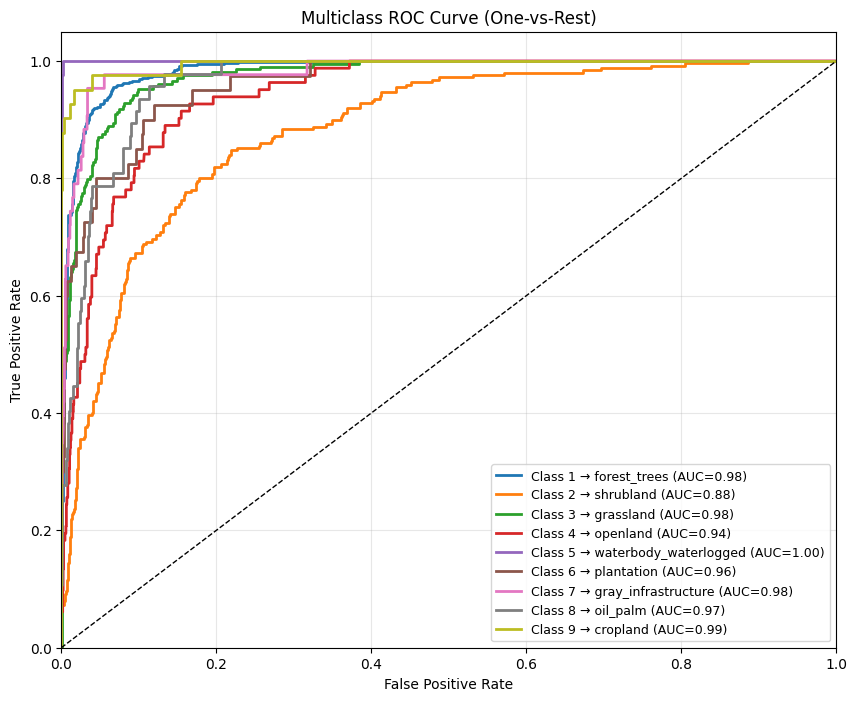


📊 Detailed Classification Report:
                       precision    recall  f1-score   support

         forest_trees       0.97      0.91      0.94      1001
            shrubland       0.59      0.60      0.59       250
            grassland       0.81      0.76      0.78       209
             openland       0.41      0.51      0.46        82
waterbody_waterlogged       0.95      0.98      0.96        42
           plantation       0.39      0.70      0.50        40
  gray_infrastructure       0.62      0.70      0.66        43
             oil_palm       0.40      0.47      0.43        47
             cropland       0.76      0.90      0.82        41

             accuracy                           0.81      1755
            macro avg       0.66      0.72      0.68      1755
         weighted avg       0.83      0.81      0.81      1755


🔍 Top 30 Most Important Features:
           feature  importance
green_norm_MAXIMUM    2.976046
          VARI_STD    2.920939
    green_norm_

In [149]:
# ============================================================================
# STEP 11: ADDITIONAL EVALUATION (OPTIONAL)
# ============================================================================
# Additional evaluation metrics and visualizations

# Use model_eval from previous cell
if 'model_eval' not in globals():
    model_eval = model_full if 'model_full' in globals() else load_full_area_model(config_full)[0]

# Plot ROC curve
print("\n📈 ROC Curve:")
# plot_roc_curve(X_val_eval, y_val_eval, model_eval)
plot_multiclass_roc(model_eval, X_val_eval, y_val_eval, class_label_map=config_full["label_map"])


# Detailed classification report
print("\n📊 Detailed Classification Report:")
class_names = [
    "forest_trees",
    "shrubland",
    "grassland",
    "openland",
    "waterbody_waterlogged",
    "plantation",
    "gray_infrastructure",
    "oil_palm",
    "cropland"
]

print(classification_report(y_val_eval, y_val_pred, target_names=class_names))


# Feature importance (top 20)
print("\n🔍 Top 30 Most Important Features:")
feature_importance = model_eval.get_feature_importance(type='PredictionValuesChange')
feature_names = ds_train.coords['feature'].values
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.head(30).to_string(index=False))

In [150]:
top_30_feat = importance_df['feature'].unique()[:30]
top_30_feat

array(['green_norm_MAXIMUM', 'VARI_STD', 'green_norm_STD', 'VARI_MEAN',
       'green_norm_MEAN', 'green_norm_MEDIAN', 'BAI_STD', 'VARI_MAXIMUM',
       'nir_norm_STD', 'VARI_MEDIAN', 'FCD2_1_MEAN', 'VARI_MINIMUM',
       'MSR_STD', 'red_norm_MEAN', 'red_norm_STD', 'red_norm_MEDIAN',
       'CRI700_MEAN', 'green_norm_MINIMUM', 'ndwi_MINIMUM', 'CRI700_STD',
       'ndwi_STD', 'FCD2_1_STD', 'CRI700_MINIMUM', 'FCD2_1_MINIMUM',
       'ndwi_MAXIMUM', 'ndwi_MEAN', 'blue_norm_STD', 'FCD2_1_MEDIAN',
       'red_norm_MAXIMUM', 'NDREI_STD'], dtype=object)

In [151]:
## rerun model with the 20 features
ds_train_top_30 = ds_train.sel(feature=top_30_feat)
# ds_train_top_20
print('running model 20 features')
model_full_20feat, model_path20feat = train_full_area_model(
    ds_train_top_30, 
    config_full, 
    validation_split=0.2,  # 20% for validation, 80% for training
    random_seed=42
)

print("\n" + "=" * 60)
print("✅ Single model trained and saved!")
print(f"   Model path: {model_path20feat}")
print(f"   Timestamp: {config_full.get('timestamp', 'N/A')}")
print(f"   Config hash: {config_full['hash']}")

running model 20 features
📊 Training on full area:
   Train samples: 7,019
   Validation samples: 1,755
   Total features: 30
   Class weights: [0.1948219202415845, 0.7811609686609686, 0.9320161461652857, 2.3835914153762565, 4.620326487625066, 4.802408319649699, 4.5343669250645995, 4.1661918328585, 4.778867102396514]
0:	learn: 2.1820188	test: 2.1818271	best: 2.1818271 (0)	total: 18.5ms	remaining: 9m 14s
100:	learn: 1.5144431	test: 1.5094744	best: 1.5094744 (100)	total: 1.36s	remaining: 6m 43s
200:	learn: 1.2906486	test: 1.2917189	best: 1.2917189 (200)	total: 2.67s	remaining: 6m 35s
300:	learn: 1.1781987	test: 1.1873631	best: 1.1873631 (300)	total: 4.06s	remaining: 6m 40s
400:	learn: 1.1032088	test: 1.1226818	best: 1.1226818 (400)	total: 5.4s	remaining: 6m 38s
500:	learn: 1.0500390	test: 1.0806622	best: 1.0806622 (500)	total: 6.74s	remaining: 6m 36s
600:	learn: 1.0088792	test: 1.0491145	best: 1.0491145 (600)	total: 8.12s	remaining: 6m 37s
700:	learn: 0.9746348	test: 1.0232937	best: 1.02

In [152]:
# !pip install shap

In [153]:
# Subsample for efficiency (adjust size as needed)
X_len = len(X_train)
if X_len == 0:
    raise ValueError("X_train is empty; cannot compute SHAP values.")
sample_size = min(1000, X_len)
idx = np.random.choice(X_len, size=sample_size, replace=False)

if isinstance(X_train, np.ndarray):
    X_sample = X_train[idx]
elif hasattr(X_train, "iloc"):  # pandas DataFrame/Series
    X_sample = X_train.iloc[idx]
else:  # e.g., xarray DataArray or other array-like
    X_sample = np.asarray(getattr(X_train, "values", X_train))[idx]

In [154]:
import shap

# Build explainer and compute SHAP values (CatBoost multi-class safe)
model_for_shap = model_full if 'model_full' in globals() else model_eval
if model_for_shap is None:
    raise ValueError("No trained model available for SHAP computation.")

# Use ds_train feature coord names to avoid generic f0..fn
if 'ds_train' in globals() and hasattr(ds_train, 'coords') and 'feature' in ds_train.coords:
    feature_names = list(ds_train.coords['feature'].values)
    X_train = ds_train.X_features.values
else:
    # Fallback to X_train already in scope
    feature_names = list(X_train.columns) if hasattr(X_train, "columns") else [f"f{i}" for i in range(X_train.shape[1])]
    X_train = np.asarray(getattr(X_train, "values", X_train))

feature_names = [str(x) for x in feature_names]

# Subsample for SHAP
X_len = len(X_train)
if X_len == 0:
    raise ValueError("X_train is empty; cannot compute SHAP values.")
sample_size = min(1000, X_len)
idx = np.random.choice(X_len, size=sample_size, replace=False)
X_sample = X_train[idx]

explainer = shap.TreeExplainer(model_for_shap)
shap_values = explainer.shap_values(X_sample)

# Normalize SHAP array and detect feature axis dynamically
if isinstance(shap_values, list):
    shap_array = np.stack([np.abs(sv) for sv in shap_values])  # (n_classes, n_samples, n_features)
else:
    shap_array = np.abs(np.asarray(shap_values))

if shap_array.ndim < 2:
    raise ValueError(f"Unexpected SHAP shape {shap_array.shape}")

# Find which axis matches the number of features
feature_axis_candidates = [i for i, s in enumerate(shap_array.shape) if s == len(feature_names)]
if not feature_axis_candidates:
    raise ValueError(
        f"Could not find feature axis of length {len(feature_names)} in SHAP shape {shap_array.shape}"
    )
feature_axis = feature_axis_candidates[-1]  # prefer the last match

# Move feature axis to the end, then average all other axes
shap_feat_last = np.moveaxis(shap_array, feature_axis, -1)
mean_abs_shap = shap_feat_last.mean(axis=tuple(range(shap_feat_last.ndim - 1)))  # -> (n_features,)

# Rank features
mean_abs_shap = np.asarray(mean_abs_shap).reshape(-1)
order = np.asarray(np.argsort(mean_abs_shap)[::-1]).reshape(-1)
top_n = min(50, len(feature_names))
order_list = [int(i) for i in order[:top_n]]
selected_features = [feature_names[i] for i in order_list]
selected_importances = [float(mean_abs_shap[i]) for i in order_list]

print("Top features (by mean |SHAP|):")
for name, val in zip(selected_features, selected_importances):
    print(f"{name}: {val:.6f}")

# Helper to subset features across common array types
def subset_features(X, feature_names, keep):
    if hasattr(X, "columns"):  # pandas
        return X[keep]
    if hasattr(X, "coords") and hasattr(X, "dims"):  # xarray DataArray
        feat_dim = X.dims[-1]
        return X.sel({feat_dim: keep})
    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    idx = [name_to_idx[k] for k in keep]
    return np.asarray(getattr(X, "values", X))[..., idx]

# Apply selection to your splits (guard if they don't exist)
X_train_sel = subset_features(X_train, feature_names, selected_features)
if 'X_valid' in globals():
    X_valid_sel = subset_features(X_valid, feature_names, selected_features)
if 'X_test' in globals():
    X_test_sel = subset_features(X_test, feature_names, selected_features)

Top features (by mean |SHAP|):
VARI_MEAN: 0.200477
green_norm_MEAN: 0.177349
FCD2_1_MEAN: 0.171864
VARI_MAXIMUM: 0.170182
red_norm_MEAN: 0.168575
VARI_MINIMUM: 0.148535
VARI_STD: 0.145101
VARI_MEDIAN: 0.140999
red_norm_MEDIAN: 0.140269
green_norm_MEDIAN: 0.135619
MSR_STD: 0.126500
green_norm_MAXIMUM: 0.116076
ndwi_MINIMUM: 0.115019
FCD2_1_MEDIAN: 0.114697
red_norm_STD: 0.111243
FCD2_1_MINIMUM: 0.110298
FCD2_1_MAXIMUM: 0.107492
green_norm_STD: 0.106462
ndwi_MEAN: 0.103954
CRI700_MEAN: 0.103412
nir_norm_STD: 0.101824
BAI_STD: 0.100889
green_norm_MINIMUM: 0.099796
red_norm_MAXIMUM: 0.090511
NDREI_MEAN: 0.086975
blue_norm_STD: 0.084575
FCD2_1_STD: 0.082798
ndwi_MAXIMUM: 0.081294
CRI700_MAXIMUM: 0.080434
CRI700_MINIMUM: 0.079670
ndwi_STD: 0.074237
blue_norm_MEAN: 0.071925
ndwi_MEDIAN: 0.070781
CRI700_STD: 0.068519
MSR_MEAN: 0.060039
FCD1_1_STD: 0.058706
NDVI_STD: 0.057544
blue_norm_MAXIMUM: 0.054507
nir_norm_MINIMUM: 0.054310
CRI700_MEDIAN: 0.054290
NDVI_MINIMUM: 0.053157
red_norm_MINIMUM: 

In [155]:
# === Train CatBoost on top-30 SHAP features ===
import numpy as np

top_k = 30
feature_subset = selected_features[:top_k]

# Align subset to ds_train feature order
all_feats = list(ds_train.coords["feature"].values)
feat_idx = [all_feats.index(f) for f in feature_subset if f in all_feats]

if len(feat_idx) != len(feature_subset):
    missing = sorted(set(feature_subset) - set(all_feats))
    raise ValueError(f"Missing features in ds_train: {missing}")

# Filter dataset to selected features
ds_train_shap = ds_train.isel(feature=feat_idx)

# Recompute class weights on the filtered dataset
y_all = ds_train_shap.y.values
class_ids, counts = np.unique(y_all, return_counts=True)
class_weight_map = {cid: (len(y_all) / (len(class_ids) * cnt)) for cid, cnt in zip(class_ids, counts)}

# Keep label map consistent with earlier config_full (fall back to sorted ids)
if "config_full" in globals() and "label_map" in config_full:
    label_map = config_full["label_map"]
else:
    label_map = {int(cid): f"class_{cid}" for cid in class_ids}

sorted_ids = sorted(label_map.keys())
class_weights = [class_weight_map.get(cid, 1.0) for cid in sorted_ids]

model_config_shap = dict(
    iterations=10000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=6,
    eval_metric="MultiClass",
    random_seed=42,
    early_stopping_rounds=300,
    verbose=100,
    use_best_model=True,
    class_weights=class_weights,
)

# Prepare config with hash; force retrain to avoid cache reuse
config_full_shap = prepare_config(
    model_config_shap,
    np.unique(ds_train_shap["plot_id"].values),
    {"force_retrain": True},
)
config_full_shap["label_map"] = label_map

print(f"📝 Config hash (SHAP-30): {config_full_shap['hash']}")
print(f"Class weights (sorted by label_map keys {sorted_ids}): {class_weights}")

print("\n🚀 Training single model on top-30 SHAP features...")
print("=" * 60)
model_full_shap, model_path_shap = train_full_area_model(
    ds_train_shap,
    config_full_shap,
    validation_split=0.2,
    random_seed=42,
)

print("\n" + "=" * 60)
print("✅ SHAP-30 model trained and saved!")
print(f"   Model path: {model_path_shap}")
print(f"   Timestamp: {config_full_shap.get('timestamp', 'N/A')}")
print(f"   Config hash: {config_full_shap['hash']}")

📝 Config hash (SHAP-30): 5698947182be561a4dc5265f3e3da81f
Class weights (sorted by label_map keys [1, 2, 3, 4, 5, 6, 7, 8, 9]): [np.float64(0.1948219202415845), np.float64(0.7811609686609686), np.float64(0.9320161461652857), np.float64(2.3835914153762565), np.float64(4.620326487625066), np.float64(4.802408319649699), np.float64(4.5343669250645995), np.float64(4.1661918328585), np.float64(4.778867102396514)]

🚀 Training single model on top-30 SHAP features...
📊 Training on full area:
   Train samples: 7,019
   Validation samples: 1,755
   Total features: 30
   Class weights: [np.float64(0.1948219202415845), np.float64(0.7811609686609686), np.float64(0.9320161461652857), np.float64(2.3835914153762565), np.float64(4.620326487625066), np.float64(4.802408319649699), np.float64(4.5343669250645995), np.float64(4.1661918328585), np.float64(4.778867102396514)]
0:	learn: 2.1438165	test: 2.1442770	best: 2.1442770 (0)	total: 40ms	remaining: 6m 40s
100:	learn: 1.0568246	test: 1.1018333	best: 1.1018

✅ Using model from training
✅ Using stored train/val split indices from training

📊 Model Performance Summary:
   Training Accuracy: 0.8978
   Validation Accuracy: 0.8120

📈 Confusion Matrix (Validation Set):


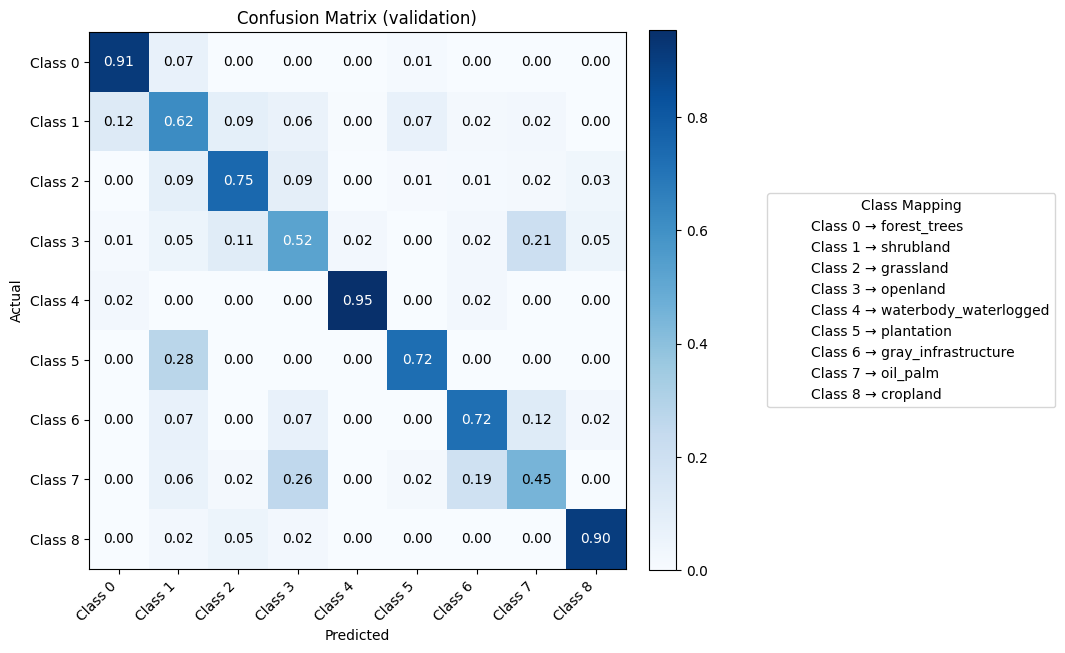

In [186]:
# ============================================================================
# STEP 10: EVALUATE TRAINED MODEL
# ============================================================================
# Evaluate the trained model on validation set and visualize results
# Note: model_full and model_path are available from the previous cell

# Use the model from training (or reload if needed)
if 'model_full' in globals():
    model_eval = model_full_shap
    print("✅ Using model from training")
else:
    # If model_full not available, load it
    model_eval, _ = load_full_area_model(config_full_shap)

ds_train = ds_train_shap

# Get the exact same train/val split used during training
# (No sample weights needed - using class_weights instead)
X_all = ds_train.X_features.values
y_all = ds_train.y.values

# Use stored indices from training (if available) or recreate with same seed
if 'val_indices' in config_full:
    val_indices = np.array(config_full_shap['val_indices'])
    train_indices = np.array(config_full_shap['train_indices'])
    print("✅ Using stored train/val split indices from training")
else:
    # Fallback: recreate split with same seed
    train_indices, val_indices = train_test_split(
        np.arange(len(X_all)),
        test_size=0.2,
        random_state=42,
        stratify=y_all
    )
    print("⚠️ Recreating split (stored indices not found)")

X_train_eval = X_all[train_indices]
X_val_eval = X_all[val_indices]
y_train_eval = y_all[train_indices]
y_val_eval = y_all[val_indices]

# Get predictions
y_train_pred = model_eval.predict(X_train_eval)
y_val_pred = model_eval.predict(X_val_eval)

# Calculate accuracies
train_acc = accuracy_score(y_train_eval, y_train_pred)
val_acc = accuracy_score(y_val_eval, y_val_pred)

print(f"\n📊 Model Performance Summary:")
print(f"   Training Accuracy: {train_acc:.4f}")
print(f"   Validation Accuracy: {val_acc:.4f}")

# Plot confusion matrix
print("\n📈 Confusion Matrix (Validation Set):")
# plot_confusion_matrix(y_val_eval, y_val_pred, dataset="validation")

plot_confusion_matrix(y_val_eval, y_val_pred, class_label_map=config_full_shap['label_map'], dataset="validation")
# plot_classification_report(y_val_eval, y_val_pred, class_label_map=config_full['label_map'])

In [188]:
# Override to enforce SHAP split indices (avoid mixing with full-feature config)
if 'config_full_shap' in globals() and 'val_indices' in config_full_shap:
    val_indices = np.array(config_full_shap['val_indices'])
    train_indices = np.array(config_full_shap['train_indices'])
    print("✅ Override: using SHAP train/val split indices")


✅ Override: using SHAP train/val split indices



📈 ROC Curve:


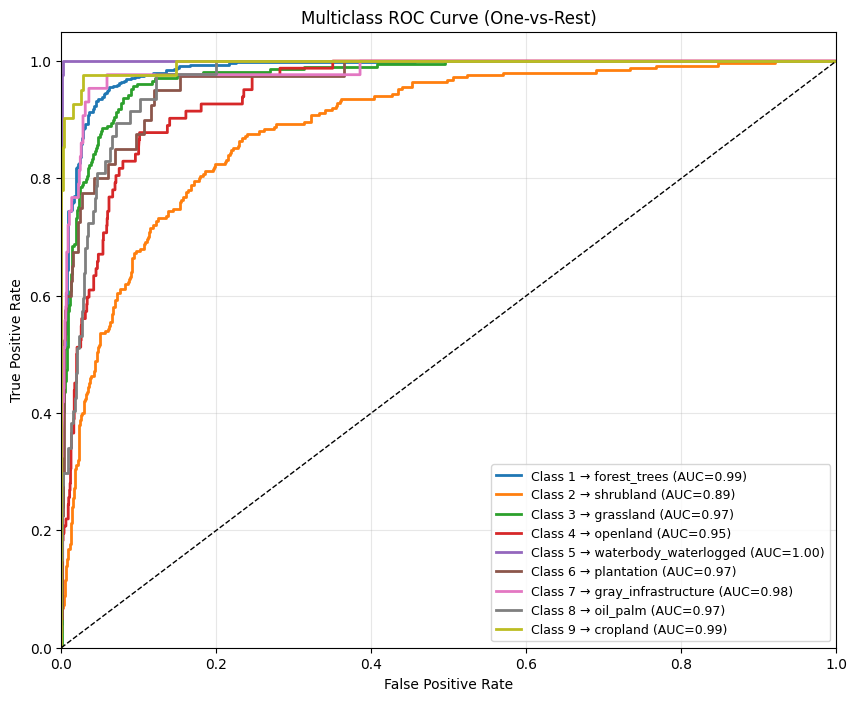


📊 Detailed Classification Report:
                       precision    recall  f1-score   support

         forest_trees       0.97      0.91      0.94      1001
            shrubland       0.58      0.62      0.60       250
            grassland       0.82      0.75      0.78       209
             openland       0.45      0.52      0.49        82
waterbody_waterlogged       0.93      0.95      0.94        42
           plantation       0.47      0.72      0.57        40
  gray_infrastructure       0.62      0.72      0.67        43
             oil_palm       0.40      0.45      0.42        47
             cropland       0.76      0.90      0.82        41

             accuracy                           0.81      1755
            macro avg       0.66      0.73      0.69      1755
         weighted avg       0.83      0.81      0.82      1755



In [189]:
# ============================================================================
# STEP 11: ADDITIONAL EVALUATION (OPTIONAL)
# ============================================================================
# Additional evaluation metrics and visualizations

# Use model_eval from previous cell
if 'model_eval' not in globals():
    model_eval = model_full if 'model_full' in globals() else load_full_area_model(config_full_shap)[0]

# Plot ROC curve
print("\n📈 ROC Curve:")
# plot_roc_curve(X_val_eval, y_val_eval, model_eval)
plot_multiclass_roc(model_eval, X_val_eval, y_val_eval, class_label_map=config_full_shap["label_map"])


# Detailed classification report
print("\n📊 Detailed Classification Report:")
class_names = [
    "forest_trees",
    "shrubland",
    "grassland",
    "openland",
    "waterbody_waterlogged",
    "plantation",
    "gray_infrastructure",
    "oil_palm",
    "cropland"
]

print(classification_report(y_val_eval, y_val_pred, target_names=class_names))

In [190]:
## kappa coefficient
## Kappa Coefficient
from sklearn.metrics import cohen_kappa_score

# Ensure we have validation predictions from the previous cell
if 'y_val_eval' not in globals() or 'y_val_pred' not in globals():
    raise ValueError("Run the accuracy/confusion matrix cell first to populate y_val_eval and y_val_pred.")

kappa = cohen_kappa_score(y_val_eval, y_val_pred)
print(f"🧮 Cohen's Kappa (validation): {kappa:.4f}")

🧮 Cohen's Kappa (validation): 0.7115


In [191]:
#################

In [192]:
feature_subset

['VARI_MEAN',
 'green_norm_MEAN',
 'FCD2_1_MEAN',
 'VARI_MAXIMUM',
 'red_norm_MEAN',
 'VARI_MINIMUM',
 'VARI_STD',
 'VARI_MEDIAN',
 'red_norm_MEDIAN',
 'green_norm_MEDIAN',
 'MSR_STD',
 'green_norm_MAXIMUM',
 'ndwi_MINIMUM',
 'FCD2_1_MEDIAN',
 'red_norm_STD',
 'FCD2_1_MINIMUM',
 'FCD2_1_MAXIMUM',
 'green_norm_STD',
 'ndwi_MEAN',
 'CRI700_MEAN',
 'nir_norm_STD',
 'BAI_STD',
 'green_norm_MINIMUM',
 'red_norm_MAXIMUM',
 'NDREI_MEAN',
 'blue_norm_STD',
 'FCD2_1_STD',
 'ndwi_MAXIMUM',
 'CRI700_MAXIMUM',
 'CRI700_MINIMUM']

In [193]:
# ============================================================================
# Full AOI dataset (all pixels, not only valid training samples)
# ============================================================================
# Tip: keep AOI feature order identical to training. If ds_train.attrs["feature_order"]
# exists, prefer that; otherwise rely on feature_subset used for the model.

# Ensure feature_subset is defined (e.g., selected_features[:30] used to train model_full_shap)
ds_ml_input_subset = ds_stacked_formatted.sel(feature=feature_subset)

ds_ml_input_subset

<xarray.Dataset> Size: 672MB
Dimensions:     (sample: 4197230, feature: 30)
Coordinates:
  * feature     (feature) object 240B 'VARI_MEAN' ... 'CRI700_MINIMUM'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 504MB dask.array<chunksize=(2000000, 30), meta=np.ndarray>

In [194]:
# ============================================================================
# MAP VISUALIZATION: PREDICTIONS VS ACTUAL PER PLOT
# ============================================================================
# Visualize predictions vs actual eligibility on maps using xarray spatial plotting
# Using ENTIRE dataset from ds_ml (not just validation set)

print("\n🔍 Preparing predictions for entire dataset...")
print("=" * 60)

# Ensure we use the model trained on the same feature subset
if 'model_full_shap' in globals():
    model_eval = model_full_shap
    print("✅ Using SHAP-selected feature model for AOI predictions")
elif 'model_full' in globals():
    model_eval = model_full
    print("ℹ️ Using full-feature model for AOI predictions")

# Quick feature count sanity check
expected_feats = model_eval.get_feature_importance().shape[0]
actual_feats = ds_ml_input_subset.X_features.shape[1]
if expected_feats != actual_feats:
    raise ValueError(
        f"Feature count mismatch: model expects {expected_feats}, AOI data has {actual_feats}. "
        "Ensure you use the model trained with the same feature subset."
    )

chunk_size = 500000
n_samples_full = int(ds_ml_input_subset.sizes["sample"])
print(f"📊 Getting predictions for all samples in batches of {chunk_size:,}...")

pred_chunks = []
coord_x_chunks = []
coord_y_chunks = []

for start in range(0, n_samples_full, chunk_size):
    end = min(start + chunk_size, n_samples_full)
    X_chunk = ds_ml_input_subset.X_features.isel(sample=slice(start, end)).values
    preds_chunk = model_eval.predict(X_chunk)
    pred_chunks.append(np.asarray(preds_chunk))
    coord_x_chunks.append(ds_ml_input_subset.coord_x.isel(sample=slice(start, end)).values)
    coord_y_chunks.append(ds_ml_input_subset.coord_y.isel(sample=slice(start, end)).values)
    print(f"   Processed samples {start:,}–{end:,}")

y_all_pred = np.concatenate(pred_chunks)
coord_x_all = np.concatenate(coord_x_chunks)
coord_y_all = np.concatenate(coord_y_chunks)



🔍 Preparing predictions for entire dataset...
✅ Using SHAP-selected feature model for AOI predictions
📊 Getting predictions for all samples in batches of 500,000...
   Processed samples 0–500,000
   Processed samples 500,000–1,000,000
   Processed samples 1,000,000–1,500,000
   Processed samples 1,500,000–2,000,000
   Processed samples 2,000,000–2,500,000
   Processed samples 2,500,000–3,000,000
   Processed samples 3,000,000–3,500,000
   Processed samples 3,500,000–4,000,000
   Processed samples 4,000,000–4,197,230


In [196]:
# Feature alignment guard before AOI inference
if 'model_eval' not in globals():
    raise ValueError("model_eval is not defined before AOI prediction")

expected_feats = model_eval.get_feature_importance().shape[0]
actual_feats = ds_ml_input_subset.X_features.shape[1]
print(f"Expected features: {expected_feats}; AOI features: {actual_feats}")
if expected_feats != actual_feats:
    raise ValueError(
        f"Feature count mismatch: model expects {expected_feats}, AOI data has {actual_feats}. "
        "Ensure you use the model trained with the same feature subset."
    )

model_feats = list(getattr(model_eval, "feature_names_", []))
aoi_feats = list(ds_ml_input_subset.feature.values)
print(f"Model feature count: {len(model_feats)}; AOI feature count: {len(aoi_feats)}")
if model_feats:
    if model_feats != aoi_feats:
        all_numeric = all(str(f).isdigit() for f in model_feats)
        if not (all_numeric and len(model_feats) == len(aoi_feats)):
            raise ValueError("Feature mismatch between model and AOI dataset; aborting inference.")
        else:
            print("⚠️ Model feature names are numeric; assuming positional alignment with AOI features.")
            print(f"First 5 AOI features: {aoi_feats[:5]}")
else:
    print("ℹ️ Model does not expose feature_names_; relying on positional alignment.")



Expected features: 30; AOI features: 30
Model feature count: 30; AOI feature count: 30
⚠️ Model feature names are numeric; assuming positional alignment with AOI features.
First 5 AOI features: ['VARI_MEAN', 'green_norm_MEAN', 'FCD2_1_MEAN', 'VARI_MAXIMUM', 'red_norm_MEAN']


In [209]:
print(len(model_feats), len(aoi_feats))

30 30


ℹ️ Using ds_ml_input_subset
Expected features: 30; AOI features: 30
📊 Getting predictions for all samples in batches of 500,000...
   Processed samples 0–500,000
   Processed samples 500,000–1,000,000
   Processed samples 1,000,000–1,500,000
   Processed samples 1,500,000–2,000,000
   Processed samples 2,000,000–2,500,000
   Processed samples 2,500,000–3,000,000
   Processed samples 3,000,000–3,500,000
   Processed samples 3,500,000–4,000,000
   Processed samples 4,000,000–4,197,230
Raw class distribution (shifted): {1: 365583, 2: 1418109, 3: 1279774, 4: 496431, 5: 30222, 6: 167505, 7: 157589, 8: 205742, 9: 76275}
Masked class distribution: {1: 365583, 2: 1418109, 3: 1279774, 4: 496431, 5: 30222, 6: 167505, 7: 157589, 8: 205742, 9: 76275}


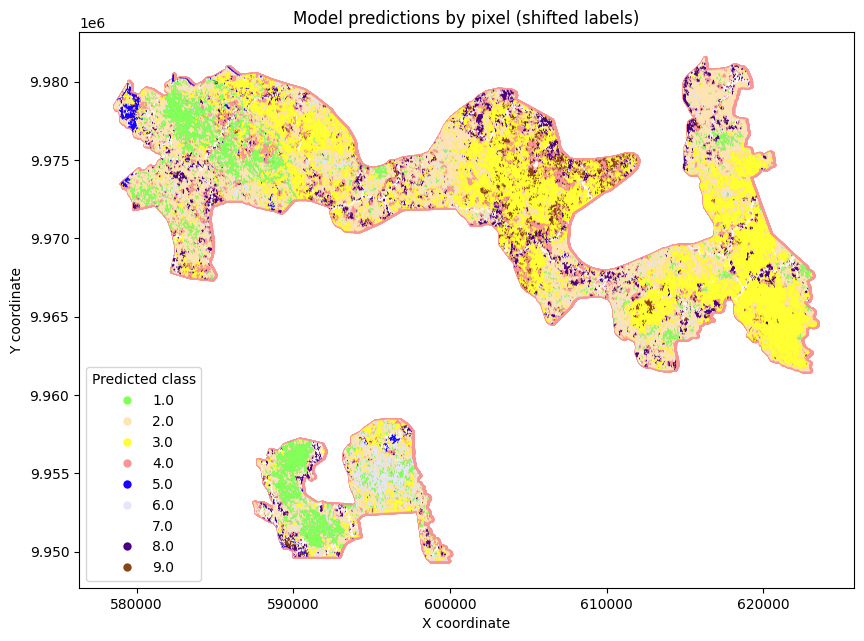

In [244]:
# Re-run AOI prediction with explicit 0→1 label shift guard
# Uses ds_ml_input_subset if present; otherwise falls back to ds_ml_input_valid

# Select AOI dataset
if 'ds_ml_input_subset' in globals():
    aoi_ds = ds_ml_input_subset
    print("ℹ️ Using ds_ml_input_subset")
else:
    aoi_ds = ds_ml_input_valid
    print("ℹ️ Using ds_ml_input_valid")

# Feature count check
expected_feats = model_eval.get_feature_importance().shape[0]
aoi_feats_n = aoi_ds.X_features.shape[1]
print(f"Expected features: {expected_feats}; AOI features: {aoi_feats_n}")
if expected_feats != aoi_feats_n:
    raise ValueError("Feature count mismatch between model and AOI dataset")

# Predict in chunks
chunk_size = 500000
n_samples_full = int(aoi_ds.sizes["sample"])
print(f"📊 Getting predictions for all samples in batches of {chunk_size:,}...")

pred_chunks, cx_chunks, cy_chunks = [], [], []
for start in range(0, n_samples_full, chunk_size):
    end = min(start + chunk_size, n_samples_full)
    X_chunk = aoi_ds.X_features.isel(sample=slice(start, end)).values
    preds_chunk = model_eval.predict(X_chunk)
    pred_chunks.append(np.asarray(preds_chunk))
    cx_chunks.append(aoi_ds.coord_x.isel(sample=slice(start, end)).values)
    cy_chunks.append(aoi_ds.coord_y.isel(sample=slice(start, end)).values)
    print(f"   Processed samples {start:,}–{end:,}")

y_all_pred = np.concatenate(pred_chunks)
coord_x_all = np.concatenate(cx_chunks)
coord_y_all = np.concatenate(cy_chunks)

# Convert labels and apply 0→1 shift if needed
pred_classes = np.asarray(y_all_pred).reshape(-1)
class_ids = list(range(1, 10))  # expected labels 1..9
if pred_classes.min() == 0 and pred_classes.max() == 8:
    pred_classes = pred_classes + 1
elif not np.all(np.isin(pred_classes, class_ids)):
    raise ValueError(f"Unexpected classes: {np.setdiff1d(pred_classes, class_ids)}")

# Distributions
uniq_raw, cnt_raw = np.unique(pred_classes, return_counts=True)
print("Raw class distribution (shifted):", {int(u): int(c) for u, c in zip(uniq_raw, cnt_raw)})

valid_pred_mask = np.isin(pred_classes, class_ids)
pred_classes_plot = pred_classes[valid_pred_mask]
coord_x_plot = coord_x_all.reshape(-1)[valid_pred_mask]
coord_y_plot = coord_y_all.reshape(-1)[valid_pred_mask]
uniq_masked, cnt_masked = np.unique(pred_classes_plot, return_counts=True)
print("Masked class distribution:", {int(u): int(c) for u, c in zip(uniq_masked, cnt_masked)})

# Plot
palette_class_segment = {
    '1': '#83ff5a',   # forest_trees (1)
    '2': '#ffe3b3',   # shrubland (2)
    '3': '#ffff33',   # grassland (3)
    '4': '#f89696',   # openland (4)
    '5': '#1900ff',   # waterbody_waterlogged (5)
    '6': '#e6e6fa',   # plantation (6)
    '7': '#FFFFFF',   # gray_infrastructure (7)
    '8': '#4B0082',   # oil_palm (8)
    '9': '#8B4513',   # cropland (9)
    '10': '#87CEEB',  # waterbody (10)
    '11': '#2F4F4F',  # wetlands (11)
    '12': '#ADFF2F',  # forest_trees_regrowth (12)
    '13': '#8B0000',  # historical_treeloss_10years (13)
    '14': '#DAA520',  # paddy_irrigated (14)
}
color_lookup = {cid: palette_class_segment[str(cid)] for cid in class_ids if str(cid) in palette_class_segment}
point_colors = [color_lookup.get(int(cid), '#000000') for cid in pred_classes_plot]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(coord_x_plot, coord_y_plot, c=point_colors, s=2, linewidths=0)
ax.set_title("Model predictions by pixel (shifted labels)")
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.set_aspect('equal')

present_classes = sorted(np.unique(pred_classes_plot))
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label=str(cid),
           markerfacecolor=color_lookup.get(int(cid), '#000000'), markersize=6, markeredgewidth=0)
    for cid in present_classes
]
ax.legend(handles=legend_elems, title="Predicted class", loc="best")
plt.show()



In [226]:
ds_ml_input_subset

<xarray.Dataset> Size: 672MB
Dimensions:     (sample: 4197230, feature: 30)
Coordinates:
  * feature     (feature) object 240B 'VARI_MEAN' ... 'CRI700_MINIMUM'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 504MB dask.array<chunksize=(2000000, 30), meta=np.ndarray>

In [225]:
y_all_pred

array([[4.],
       [4.],
       [4.],
       ...,
       [4.],
       [4.],
       [4.]], shape=(4197230, 1))

In [223]:
pred_classes

array([4., 4., 4., ..., 4., 4., 4.], shape=(4197230,))

In [207]:
ds_ml_input_subset

<xarray.Dataset> Size: 672MB
Dimensions:     (sample: 4197230, feature: 30)
Coordinates:
  * feature     (feature) object 240B 'VARI_MEAN' ... 'CRI700_MINIMUM'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 504MB dask.array<chunksize=(2000000, 30), meta=np.ndarray>

In [208]:
model_eval.feature_names_

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29']

In [227]:
# Attach predicted class (1..9) back to AOI dataset for downstream use

aoi_with_pred = aoi_ds.assign(
    pred_class=("sample", pred_classes.astype(int)),
)

print(aoi_with_pred)



<xarray.Dataset> Size: 705MB
Dimensions:     (sample: 4197230, feature: 30)
Coordinates:
  * feature     (feature) object 240B 'VARI_MEAN' ... 'CRI700_MINIMUM'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 504MB dask.array<chunksize=(2000000, 30), meta=np.ndarray>
    pred_class  (sample) int64 34MB 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4


In [231]:
aoi_with_pred = aoi_with_pred.assign_attrs(
    crs=forestry.config['output_crs']
)
aoi_with_pred

<xarray.Dataset> Size: 705MB
Dimensions:     (sample: 4197230, feature: 30)
Coordinates:
  * feature     (feature) object 240B 'VARI_MEAN' ... 'CRI700_MINIMUM'
  * sample      (sample) int64 34MB 306 307 308 ... 14496815 14496816 14496817
Data variables:
    coord_x     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    coord_y     (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    plot_id     (sample) object 34MB dask.array<chunksize=(4197230,), meta=np.ndarray>
    target      (sample) float64 34MB dask.array<chunksize=(2000000,), meta=np.ndarray>
    X_features  (sample, feature) float32 504MB dask.array<chunksize=(2000000, 30), meta=np.ndarray>
    pred_class  (sample) int64 34MB 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Attributes:
    crs:      EPSG:32749

In [234]:
zarr_path = 'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr'

aoi_with_pred = aoi_with_pred.unify_chunks()
# Align chunk sizes with current dask chunks to avoid zarr overlap errors
sample_chunk = aoi_with_pred.chunks.get("sample", (aoi_with_pred.sizes["sample"],))[0] if hasattr(aoi_with_pred, "chunks") else aoi_with_pred.sizes["sample"]
feature_chunk = aoi_with_pred.chunks.get("feature", (aoi_with_pred.sizes.get("feature", 1),))[0] if hasattr(aoi_with_pred, "chunks") and "feature" in aoi_with_pred.dims else aoi_with_pred.sizes.get("feature", 1)
chunk_sizes = {"sample": sample_chunk, "feature": feature_chunk}

save_dataset_efficient_zarr(aoi_with_pred, zarr_path, chunk_sizes=chunk_sizes, overwrite=True, 
    gee_compatible=False, align_chunks=True)


🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr
📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr
   Dimensions: {'sample': 4197230, 'feature': 30}
   Chunks: {'sample': 2000000, 'feature': 30}
   Compression: None
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...
[########################################] | 100% Completed | 8.48 ss
✅ Dataset saved successfully!
   Store size: 116.40 MB
   Time: 12.5 seconds (0.2 minutes)
   Write speed: 9.3 MB/s
   Path: gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr


'gs://remote_sensing_saas/01-korindo/planet_obia_arcgis/final_ds_pred_LC_20251207.zarr'

In [228]:
np.unique(aoi_with_pred.pred_class.values)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [245]:
# ============================================================================
# STEP 12: EXPORT MODEL TO GCS
# ============================================================================
# Export the trained model and config to Google Cloud Storage for deployment

print("📦 Exporting model to Google Cloud Storage...")
print("=" * 60)

config_full = config_full_shap

# Get model path from config
local_model_path = config_full_shap['model_path']
model_timestamp = config_full_shap.get('timestamp', 'unknown')
config_hash = config_full_shap.get('hash', 'unknown')

print(f"📂 Local model location:")
print(f"   {local_model_path}")

# Define GCS destination path
# Using the same bucket structure as other data
gcs_bucket = "remote_sensing_saas/01-korindo/lc_model_catboost"
gcs_model_filename = f"catboost_{model_timestamp}.cbm"
gcs_config_filename = f"config_{model_timestamp}.json"

gcs_model_path = f"{gcs_bucket}/{gcs_model_filename}"
gcs_config_path = f"{gcs_bucket}/{gcs_config_filename}"

print(f"\n☁️  GCS destination:")
print(f"   Model: {gcs_model_path}")
print(f"   Config: {gcs_config_path}")

# Check if model file exists locally
if os.path.exists(local_model_path):
    # Upload model to GCS
    print(f"\n⬆️  Uploading model to GCS...")
    with open(local_model_path, 'rb') as f:
        with fs.open(gcs_model_path, 'wb') as gcs_file:
            gcs_file.write(f.read())
    print(f"   ✅ Model uploaded: {gcs_model_filename}")
    
    # Also upload config.json if it exists
    config_json_path = f"/mnt/data/cache/{config_hash}/config.json"
    if os.path.exists(config_json_path):
        print(f"\n⬆️  Uploading config to GCS...")
        with open(config_json_path, 'rb') as f:
            with fs.open(gcs_config_path, 'wb') as gcs_file:
                gcs_file.write(f.read())
        print(f"   ✅ Config uploaded: {gcs_config_filename}")
    
    # Print summary
    print(f"\n" + "=" * 60)
    print(f"✅ Export completed!")
    print(f"   Model: {gcs_model_path}")
    print(f"   Config: {gcs_config_path}")
    print(f"   Timestamp: {model_timestamp}")
    print(f"   Hash: {config_hash}")
    print("=" * 60)
    
    # Store GCS paths in config for reference
    config_full['gcs_model_path'] = gcs_model_path
    config_full['gcs_config_path'] = gcs_config_path
    
else:
    print(f"\n❌ Error: Model file not found at {local_model_path}")
    print(f"   Please run STEP 9 to train the model first.")


📦 Exporting model to Google Cloud Storage...
📂 Local model location:
   /mnt/data/cache/5698947182be561a4dc5265f3e3da81f/catboost_20251207_142834.cbm

☁️  GCS destination:
   Model: remote_sensing_saas/01-korindo/lc_model_catboost/catboost_20251207_142834.cbm
   Config: remote_sensing_saas/01-korindo/lc_model_catboost/config_20251207_142834.json

⬆️  Uploading model to GCS...
   ✅ Model uploaded: catboost_20251207_142834.cbm

⬆️  Uploading config to GCS...
   ✅ Config uploaded: config_20251207_142834.json

✅ Export completed!
   Model: remote_sensing_saas/01-korindo/lc_model_catboost/catboost_20251207_142834.cbm
   Config: remote_sensing_saas/01-korindo/lc_model_catboost/config_20251207_142834.json
   Timestamp: 20251207_142834
   Hash: 5698947182be561a4dc5265f3e3da81f
